In [1]:
import warnings 
warnings.filterwarnings("ignore")

from monai.utils import first, set_determinism
from monai.transforms import (
    AddChanneld,
    AsChannelFirstd,
    AsDiscrete,
    AsDiscreted,
    Compose,
    EnsureChannelFirstd,
    EnsureTyped,
    EnsureType,
    Invertd,
    LabelFilterd,
    LoadImaged,
    RandFlipd,
    RandSpatialCropd,
    RandZoomd,
    Resized,
    ScaleIntensityRanged,
    SpatialCrop,
    SpatialCropd,
    ToTensord,
)
from monai.handlers.utils import from_engine
from monai.networks.nets import UNet
from monai.networks.layers import Norm
from monai.metrics import DiceMetric
from monai.losses import DiceLoss
from monai.inferers import sliding_window_inference
from monai.data import CacheDataset, DataLoader, Dataset, decollate_batch
from monai.config import print_config
from monai.apps import download_and_extract
import torch
import matplotlib.pyplot as plt
import tempfile
import shutil
import os
from glob import glob

import numpy as np

import itk

import sys

import site
site.addsitedir('../')
from ARGUSUtils_Transforms import *

In [2]:
if False: #len(sys.argv) == 3:
    device_num = int(sys.argv[1])
    num_devices = int(sys.argv[2])
    print("Using device", str(device_num),"of", str(num_devices))
else:
    print("Device number assumed to be 1")
    device_num = 1
    num_devices = 1


img1_dir = "../../Data/Final15/BAMC-PTX*Sliding-Annotations-Linear/"
    
all_images = sorted(glob(os.path.join(img1_dir, '*_?????.nii.gz')))
all_labels = sorted(glob(os.path.join(img1_dir, '*.extruded-overlay-NS.nii.gz')))

num_folds = 15

num_classes = 3

net_dims = 2
net_in_channels = 4

num_workers_tr = 1
batch_size_tr = 16
num_workers_vl = 1
batch_size_vl = 4

num_slices = 32
size_x = 160
size_y = 320


model_filename_base = "./results/BAMC_PTX_ROINet-StdDevExtended-ExtrudedNS-Final15/"

num_images = len(all_images)
print("Num images / labels =", num_images, len(all_labels))

ns_prefix = ['025ns','026ns','027ns','035ns','048ns','055ns','117ns',
             '135ns','193ns','210ns','215ns','218ns_image_60','218ns_image_63','219ns','247ns']
s_prefix = ['004s','019s','030s','034s','037s','043s','065s','081s',
            '206s','208s','211s','212s','224s','228s','236s','237s']


fold_prefix_list = []
ns_count = 0
s_count = 0
for i in range(num_folds):
    if i%2 == 0:
        num_ns = 1
        num_s = 1
        if i > num_folds-2:
            num_s = 2
    else:
        num_ns = 1
        num_s = 1
    f = []
    for ns in range(num_ns):
        f.append([ns_prefix[ns_count+ns]])
    ns_count += num_ns
    for s in range(num_s):
        f.append([s_prefix[s_count+s]])
    s_count += num_s
    fold_prefix_list.append(f)
    
for i in range(num_folds):
    print(i, fold_prefix_list[i])

Device number assumed to be 1
Num images / labels = 47 47
0 [['025ns'], ['004s']]
1 [['026ns'], ['019s']]
2 [['027ns'], ['030s']]
3 [['035ns'], ['034s']]
4 [['048ns'], ['037s']]
5 [['055ns'], ['043s']]
6 [['117ns'], ['065s']]
7 [['135ns'], ['081s']]
8 [['193ns'], ['206s']]
9 [['210ns'], ['208s']]
10 [['215ns'], ['211s']]
11 [['218ns_image_60'], ['212s']]
12 [['218ns_image_63'], ['224s']]
13 [['219ns'], ['228s']]
14 [['247ns'], ['236s'], ['237s']]


In [3]:
train_files = []
val_files = []
test_files = []
for i in range(num_folds):
    tr_folds = []
    for f in range(i,i+num_folds-2):
        tr_folds.append(fold_prefix_list[f%num_folds])
    tr_folds = list(np.concatenate(tr_folds).flat)
    va_folds = list(np.concatenate(fold_prefix_list[(i+num_folds-2) % num_folds]).flat)
    te_folds = list(np.concatenate(fold_prefix_list[(i+num_folds-1) % num_folds]).flat)
    train_files.append(
            [
                {"image": img, "label": seg}
                for img, seg in zip(
                    [im for im in all_images if any(pref in im for pref in tr_folds)],
                    [se for se in all_labels if any(pref in se for pref in tr_folds)])
            ]
        )
    val_files.append(
            [
                {"image": img, "label": seg}
                for img, seg in zip(
                    [im for im in all_images if any(pref in im for pref in va_folds)],
                    [se for se in all_labels if any(pref in se for pref in va_folds)])
            ]
        )
    test_files.append(
            [
                {"image": img, "label": seg}
                for img, seg in zip(
                    [im for im in all_images if any(pref in im for pref in te_folds)],
                    [se for se in all_labels if any(pref in se for pref in te_folds)])
            ]
        )
    print(len(train_files[i]),len(val_files[i]),len(test_files[i]))

40 3 4
40 4 3
41 3 3
41 3 3
41 3 3
42 3 2
42 2 3
41 3 3
41 3 3
41 3 3
40 3 4
40 4 3
40 3 4
40 4 3
41 3 3


../../Data/Final15/BAMC-PTXNoSliding-Annotations-Linear/026ns_image_1083297968960_clean.nii.gz
../../Data/Final15/BAMC-PTXNoSliding-Annotations-Linear/026ns_image_1083297968960_clean.extruded-overlay-NS.nii.gz


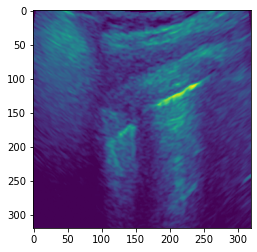

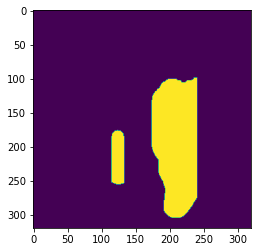

In [4]:
imgnum = 1 #10 for ns, 0 for s

print(train_files[0][imgnum]["image"])
print(train_files[0][imgnum]["label"])

img = itk.imread(train_files[0][imgnum]["image"])
arrimg = itk.GetArrayFromImage(img)
img = itk.imread(train_files[0][imgnum]["label"])
arrlbl = itk.GetArrayFromImage(img)

plt.subplots()
plt.imshow(arrimg[0,:,:])
plt.subplots()
plt.imshow(arrlbl[0,:,:])

In [5]:
train_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        AsChannelFirstd(keys='image'),
        AsChannelFirstd(keys='label'),
        ScaleIntensityRanged(
            a_min=0, a_max=255,
            b_min=0.0, b_max=1.0,
            keys=["image"]),
        SpatialCropd(
            roi_start=[80,0,1],
            roi_end=[240,320,61],
            keys=["image", "label"]),
        ARGUS_RandSpatialCropSlicesd(
            num_slices=[num_slices,1],
            axis=0,
            reduce_to_statistics=[True,False],
            extended=True,
            keys=['image', 'label']),
        RandFlipd(prob=0.5, 
            spatial_axis=0,
            keys=['image', 'label']),
        RandZoomd(prob=0.5, 
            min_zoom=1.0,
            max_zoom=1.2,
            keep_size=True,
            mode=['bilinear', 'nearest'],
            keys=['image', 'label']),
        ToTensord(keys=["image", "label"]),
    ]
)
val_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        AsChannelFirstd(keys='image'),
        AsChannelFirstd(keys='label'),
        ScaleIntensityRanged(
            a_min=0, a_max=255,
            b_min=0.0, b_max=1.0,
            keys=["image"]),
        SpatialCropd(
            roi_start=[80,0,1],
            roi_end=[240,320,61],
            keys=["image", "label"]),
        ARGUS_RandSpatialCropSlicesd(
            num_slices=[num_slices,1],
            axis=0,
            reduce_to_statistics=[True,False],
            extended=True,
            keys=['image', 'label']),
        ToTensord(keys=["image", "label"]),
    ]
)

In [6]:
train_ds = [CacheDataset(data=train_files[i], transform=train_transforms,cache_rate=1.0, num_workers=num_workers_tr)
            for i in range(num_folds)]
train_loader = [DataLoader(train_ds[i], batch_size=batch_size_tr, shuffle=True, num_workers=num_workers_tr) 
                for i in range(num_folds)]

val_ds = [CacheDataset(data=val_files[i], transform=val_transforms, cache_rate=1.0, num_workers=num_workers_vl)
          for i in range(num_folds)]
val_loader = [DataLoader(val_ds[i], batch_size=batch_size_vl, num_workers=num_workers_vl)
              for i in range(num_folds)]

Loading dataset: 100%|████████████████████████████| 3/3 [00:00<00:00,  7.85it/s]


torch.Size([3, 4, 160, 320])
torch.Size([4, 160, 320])
image shape: torch.Size([4, 160, 320]), label shape: torch.Size([1, 160, 320])


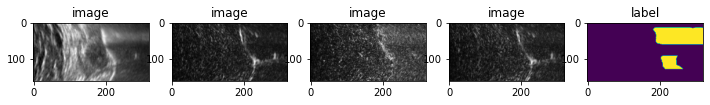

tensor(0.) tensor(2.)


In [7]:
imgnum = 2
check_data = first(val_loader[0])
image, label = (check_data["image"][imgnum], check_data["label"][imgnum])
print(check_data["image"].shape)
print(image.shape)
print(f"image shape: {image.shape}, label shape: {label.shape}")
plt.figure("check", (12, 6))
plt.subplot(1, 5, 1)
plt.title("image")
plt.imshow(image[0, :, :], cmap="gray")
plt.subplot(1, 5, 2)
plt.title("image")
plt.imshow(image[1, :, :], cmap="gray")
plt.subplot(1, 5, 3)
plt.title("image")
plt.imshow(image[2, :, :], cmap="gray")
plt.subplot(1, 5, 4)
plt.title("image")
plt.imshow(image[3, :, :], cmap="gray")
plt.subplot(1, 5, 5)
plt.title("label")
plt.imshow(label[0, :, :])
plt.show()
print(label.min(), label.max())

In [8]:
device = torch.device("cuda:"+str(device_num))

max_epochs = 500
net_channels=(32, 64, 128)
net_strides=(2, 2)

In [9]:
def vfold_train(vfold_num, train_loader, val_loader):
    model = UNet(
        dimensions=net_dims,
        in_channels=net_in_channels,
        out_channels=num_classes,
        channels=net_channels,
        strides=net_strides,
        num_res_units=2,
        norm=Norm.BATCH,
    ).to(device)
    loss_function = DiceLoss(to_onehot_y=True, softmax=True)
    optimizer = torch.optim.Adam(model.parameters(), 1e-4)
    dice_metric = DiceMetric(include_background=False, reduction="mean")

    val_interval = 2
    best_metric = -1
    best_metric_epoch = -1
    epoch_loss_values = []
    metric_values = []

    post_pred = Compose([EnsureType(), AsDiscrete(argmax=True, to_onehot=True, num_classes=num_classes)])
    post_label = Compose([EnsureType(), AsDiscrete(to_onehot=True, num_classes=num_classes)])

    for epoch in range(max_epochs):
        print("-" * 10)
        print(f"{vfold_num}: epoch {epoch + 1}/{max_epochs}")
        model.train()
        epoch_loss = 0
        step = 0
        for batch_data in train_loader:
            step += 1
            inputs, labels = (
                batch_data["image"].to(device),
                batch_data["label"].to(device),
            )
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = loss_function(outputs, labels)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
            print(f"{step}/{len(train_ds) // train_loader.batch_size}, "
                  f"train_loss: {loss.item():.4f}")
        epoch_loss /= step
        epoch_loss_values.append(epoch_loss)
        print(f"{vfold_num} epoch {epoch + 1} average loss: {epoch_loss:.4f}")

        if (epoch + 1) % val_interval == 0:
            model.eval()
            with torch.no_grad():
                for val_data in val_loader:
                    val_inputs, val_labels = (
                        val_data["image"].to(device),
                        val_data["label"].to(device),
                    )
                    roi_size = (size_x, size_y)
                    sw_batch_size = batch_size_vl
                    val_outputs = sliding_window_inference(
                        val_inputs, roi_size, sw_batch_size, model)
                    val_outputs = [post_pred(i) for i in decollate_batch(val_outputs)]
                    val_labels = [post_label(i) for i in decollate_batch(val_labels)]
                    # compute metric for current iteration
                    dice_metric(y_pred=val_outputs, y=val_labels)

                # aggregate the final mean dice result
                metric = dice_metric.aggregate().item()
                # reset the status for next validation round
                dice_metric.reset()

                metric_values.append(metric)
                if epoch > 100:
                    metric = (metric_values[-1]+metric_values[-2]+metric_values[-3])/3
                    if metric > best_metric:
                        best_metric = metric
                        best_metric_epoch = epoch + 1
                        torch.save(model.state_dict(), model_filename_base+'best_model.vfold_'+str(vfold_num)+'.pth')
                        print("saved new best metric model")
                print(
                    f"current epoch: {epoch + 1} current mean dice: {metric:.4f}"
                    f"\nbest mean dice: {best_metric:.4f} "
                    f"at epoch: {best_metric_epoch}"
                )
                torch.save(model.state_dict(), model_filename_base+'last_model.vfold_'+str(vfold_num)+'.pth')

    np.save(model_filename_base+"loss_"+str(vfold_num)+".npy", epoch_loss_values)
    np.save(model_filename_base+"val_dice_"+str(vfold_num)+".npy", metric_values)

    

In [ ]:
for i in range(0,num_folds,num_devices):
        vfold_train(i, train_loader[i], val_loader[i])

----------
0: epoch 1/500
1/0, train_loss: 0.7512
2/0, train_loss: 0.7451
3/0, train_loss: 0.7437
0 epoch 1 average loss: 0.7467
----------
0: epoch 2/500
1/0, train_loss: 0.7285
2/0, train_loss: 0.7342
3/0, train_loss: 0.7113
0 epoch 2 average loss: 0.7247
current epoch: 2 current mean dice: 0.1015
best mean dice: -1.0000 at epoch: -1
----------
0: epoch 3/500
1/0, train_loss: 0.7189
2/0, train_loss: 0.7115
3/0, train_loss: 0.6989
0 epoch 3 average loss: 0.7097
----------
0: epoch 4/500
1/0, train_loss: 0.6964
2/0, train_loss: 0.7036
3/0, train_loss: 0.7085
0 epoch 4 average loss: 0.7028
current epoch: 4 current mean dice: 0.2029
best mean dice: -1.0000 at epoch: -1
----------
0: epoch 5/500
1/0, train_loss: 0.6858
2/0, train_loss: 0.6859
3/0, train_loss: 0.6963
0 epoch 5 average loss: 0.6894
----------
0: epoch 6/500
1/0, train_loss: 0.6865
2/0, train_loss: 0.6738
3/0, train_loss: 0.6751
0 epoch 6 average loss: 0.6784
current epoch: 6 current mean dice: 0.2290
best mean dice: -1.0000

1/0, train_loss: 0.5814
2/0, train_loss: 0.5808
3/0, train_loss: 0.6052
0 epoch 49 average loss: 0.5891
----------
0: epoch 50/500
1/0, train_loss: 0.5895
2/0, train_loss: 0.5890
3/0, train_loss: 0.5924
0 epoch 50 average loss: 0.5903
current epoch: 50 current mean dice: 0.5722
best mean dice: -1.0000 at epoch: -1
----------
0: epoch 51/500
1/0, train_loss: 0.5850
2/0, train_loss: 0.6072
3/0, train_loss: 0.5709
0 epoch 51 average loss: 0.5877
----------
0: epoch 52/500
1/0, train_loss: 0.5929
2/0, train_loss: 0.5875
3/0, train_loss: 0.5697
0 epoch 52 average loss: 0.5834
current epoch: 52 current mean dice: 0.7476
best mean dice: -1.0000 at epoch: -1
----------
0: epoch 53/500
1/0, train_loss: 0.5750
2/0, train_loss: 0.6018
3/0, train_loss: 0.5709
0 epoch 53 average loss: 0.5826
----------
0: epoch 54/500
1/0, train_loss: 0.5840
2/0, train_loss: 0.6012
3/0, train_loss: 0.5680
0 epoch 54 average loss: 0.5844
current epoch: 54 current mean dice: 0.6144
best mean dice: -1.0000 at epoch: -

1/0, train_loss: 0.5422
2/0, train_loss: 0.5531
3/0, train_loss: 0.5816
0 epoch 97 average loss: 0.5590
----------
0: epoch 98/500
1/0, train_loss: 0.5363
2/0, train_loss: 0.5364
3/0, train_loss: 0.5677
0 epoch 98 average loss: 0.5468
current epoch: 98 current mean dice: 0.6774
best mean dice: -1.0000 at epoch: -1
----------
0: epoch 99/500
1/0, train_loss: 0.5312
2/0, train_loss: 0.5581
3/0, train_loss: 0.5729
0 epoch 99 average loss: 0.5541
----------
0: epoch 100/500
1/0, train_loss: 0.5694
2/0, train_loss: 0.5431
3/0, train_loss: 0.5371
0 epoch 100 average loss: 0.5499
current epoch: 100 current mean dice: 0.7315
best mean dice: -1.0000 at epoch: -1
----------
0: epoch 101/500
1/0, train_loss: 0.5572
2/0, train_loss: 0.5349
3/0, train_loss: 0.5634
0 epoch 101 average loss: 0.5518
----------
0: epoch 102/500
1/0, train_loss: 0.5381
2/0, train_loss: 0.5406
3/0, train_loss: 0.5525
0 epoch 102 average loss: 0.5438
saved new best metric model
current epoch: 102 current mean dice: 0.7315

2/0, train_loss: 0.5093
3/0, train_loss: 0.5330
0 epoch 144 average loss: 0.5227
current epoch: 144 current mean dice: 0.7324
best mean dice: 0.7480 at epoch: 116
----------
0: epoch 145/500
1/0, train_loss: 0.5004
2/0, train_loss: 0.5383
3/0, train_loss: 0.5459
0 epoch 145 average loss: 0.5282
----------
0: epoch 146/500
1/0, train_loss: 0.5141
2/0, train_loss: 0.5337
3/0, train_loss: 0.5027
0 epoch 146 average loss: 0.5168
current epoch: 146 current mean dice: 0.7123
best mean dice: 0.7480 at epoch: 116
----------
0: epoch 147/500
1/0, train_loss: 0.5138
2/0, train_loss: 0.5327
3/0, train_loss: 0.5139
0 epoch 147 average loss: 0.5201
----------
0: epoch 148/500
1/0, train_loss: 0.5204
2/0, train_loss: 0.5111
3/0, train_loss: 0.5180
0 epoch 148 average loss: 0.5165
current epoch: 148 current mean dice: 0.7386
best mean dice: 0.7480 at epoch: 116
----------
0: epoch 149/500
1/0, train_loss: 0.5232
2/0, train_loss: 0.5001
3/0, train_loss: 0.5161
0 epoch 149 average loss: 0.5131
--------

1/0, train_loss: 0.4895
2/0, train_loss: 0.5109
3/0, train_loss: 0.4840
0 epoch 191 average loss: 0.4948
----------
0: epoch 192/500
1/0, train_loss: 0.5048
2/0, train_loss: 0.5035
3/0, train_loss: 0.5080
0 epoch 192 average loss: 0.5054
current epoch: 192 current mean dice: 0.6636
best mean dice: 0.7480 at epoch: 116
----------
0: epoch 193/500
1/0, train_loss: 0.5007
2/0, train_loss: 0.5051
3/0, train_loss: 0.5087
0 epoch 193 average loss: 0.5049
----------
0: epoch 194/500
1/0, train_loss: 0.4947
2/0, train_loss: 0.5104
3/0, train_loss: 0.4946
0 epoch 194 average loss: 0.4999
current epoch: 194 current mean dice: 0.6882
best mean dice: 0.7480 at epoch: 116
----------
0: epoch 195/500
1/0, train_loss: 0.5016
2/0, train_loss: 0.4898
3/0, train_loss: 0.5402
0 epoch 195 average loss: 0.5106
----------
0: epoch 196/500
1/0, train_loss: 0.4851
2/0, train_loss: 0.4958
3/0, train_loss: 0.5077
0 epoch 196 average loss: 0.4962
current epoch: 196 current mean dice: 0.7225
best mean dice: 0.748

0 epoch 238 average loss: 0.4880
current epoch: 238 current mean dice: 0.7211
best mean dice: 0.7480 at epoch: 116
----------
0: epoch 239/500
1/0, train_loss: 0.4795
2/0, train_loss: 0.4879
3/0, train_loss: 0.4909
0 epoch 239 average loss: 0.4861
----------
0: epoch 240/500
1/0, train_loss: 0.4703
2/0, train_loss: 0.4994
3/0, train_loss: 0.4705
0 epoch 240 average loss: 0.4801
current epoch: 240 current mean dice: 0.7164
best mean dice: 0.7480 at epoch: 116
----------
0: epoch 241/500
1/0, train_loss: 0.4745
2/0, train_loss: 0.4831
3/0, train_loss: 0.4914
0 epoch 241 average loss: 0.4830
----------
0: epoch 242/500
1/0, train_loss: 0.4735
2/0, train_loss: 0.4607
3/0, train_loss: 0.4864
0 epoch 242 average loss: 0.4735
current epoch: 242 current mean dice: 0.7218
best mean dice: 0.7480 at epoch: 116
----------
0: epoch 243/500
1/0, train_loss: 0.4833
2/0, train_loss: 0.4826
3/0, train_loss: 0.4742
0 epoch 243 average loss: 0.4800
----------
0: epoch 244/500
1/0, train_loss: 0.4874
2/0,

0 epoch 285 average loss: 0.4794
----------
0: epoch 286/500
1/0, train_loss: 0.4685
2/0, train_loss: 0.4841
3/0, train_loss: 0.4713
0 epoch 286 average loss: 0.4746
current epoch: 286 current mean dice: 0.7118
best mean dice: 0.7480 at epoch: 116
----------
0: epoch 287/500
1/0, train_loss: 0.4621
2/0, train_loss: 0.4795
3/0, train_loss: 0.4528
0 epoch 287 average loss: 0.4648
----------
0: epoch 288/500
1/0, train_loss: 0.4590
2/0, train_loss: 0.4846
3/0, train_loss: 0.4563
0 epoch 288 average loss: 0.4666
saved new best metric model
current epoch: 288 current mean dice: 0.7530
best mean dice: 0.7530 at epoch: 288
----------
0: epoch 289/500
1/0, train_loss: 0.4827
2/0, train_loss: 0.4537
3/0, train_loss: 0.5107
0 epoch 289 average loss: 0.4824
----------
0: epoch 290/500
1/0, train_loss: 0.4780
2/0, train_loss: 0.4882
3/0, train_loss: 0.4561
0 epoch 290 average loss: 0.4741
current epoch: 290 current mean dice: 0.7408
best mean dice: 0.7530 at epoch: 288
----------
0: epoch 291/500


0 epoch 332 average loss: 0.4561
current epoch: 332 current mean dice: 0.6640
best mean dice: 0.7706 at epoch: 324
----------
0: epoch 333/500
1/0, train_loss: 0.4641
2/0, train_loss: 0.4706
3/0, train_loss: 0.4470
0 epoch 333 average loss: 0.4606
----------
0: epoch 334/500
1/0, train_loss: 0.4560
2/0, train_loss: 0.4518
3/0, train_loss: 0.4645
0 epoch 334 average loss: 0.4575
current epoch: 334 current mean dice: 0.6481
best mean dice: 0.7706 at epoch: 324
----------
0: epoch 335/500
1/0, train_loss: 0.4334
2/0, train_loss: 0.4533
3/0, train_loss: 0.4976
0 epoch 335 average loss: 0.4614
----------
0: epoch 336/500
1/0, train_loss: 0.4577
2/0, train_loss: 0.4741
3/0, train_loss: 0.4443
0 epoch 336 average loss: 0.4587
current epoch: 336 current mean dice: 0.6630
best mean dice: 0.7706 at epoch: 324
----------
0: epoch 337/500
1/0, train_loss: 0.4696
2/0, train_loss: 0.4516
3/0, train_loss: 0.4478
0 epoch 337 average loss: 0.4563
----------
0: epoch 338/500
1/0, train_loss: 0.4499
2/0,

0 epoch 379 average loss: 0.4542
----------
0: epoch 380/500
1/0, train_loss: 0.4481
2/0, train_loss: 0.4507
3/0, train_loss: 0.4812
0 epoch 380 average loss: 0.4600
current epoch: 380 current mean dice: 0.7018
best mean dice: 0.7706 at epoch: 324
----------
0: epoch 381/500
1/0, train_loss: 0.4717
2/0, train_loss: 0.4353
3/0, train_loss: 0.4534
0 epoch 381 average loss: 0.4535
----------
0: epoch 382/500
1/0, train_loss: 0.4541
2/0, train_loss: 0.4465
3/0, train_loss: 0.4498
0 epoch 382 average loss: 0.4501
current epoch: 382 current mean dice: 0.7415
best mean dice: 0.7706 at epoch: 324
----------
0: epoch 383/500
1/0, train_loss: 0.4610
2/0, train_loss: 0.4604
3/0, train_loss: 0.4456
0 epoch 383 average loss: 0.4556
----------
0: epoch 384/500
1/0, train_loss: 0.4249
2/0, train_loss: 0.4888
3/0, train_loss: 0.4490
0 epoch 384 average loss: 0.4542
saved new best metric model
current epoch: 384 current mean dice: 0.7812
best mean dice: 0.7812 at epoch: 384
----------
0: epoch 385/500


3/0, train_loss: 0.4381
0 epoch 426 average loss: 0.4515
current epoch: 426 current mean dice: 0.7624
best mean dice: 0.7881 at epoch: 418
----------
0: epoch 427/500
1/0, train_loss: 0.4363
2/0, train_loss: 0.4568
3/0, train_loss: 0.4349
0 epoch 427 average loss: 0.4427
----------
0: epoch 428/500
1/0, train_loss: 0.4532
2/0, train_loss: 0.4334
3/0, train_loss: 0.4574
0 epoch 428 average loss: 0.4480
current epoch: 428 current mean dice: 0.7711
best mean dice: 0.7881 at epoch: 418
----------
0: epoch 429/500
1/0, train_loss: 0.4554
2/0, train_loss: 0.4240
3/0, train_loss: 0.4821
0 epoch 429 average loss: 0.4539
----------
0: epoch 430/500
1/0, train_loss: 0.4370
2/0, train_loss: 0.4597
3/0, train_loss: 0.4545
0 epoch 430 average loss: 0.4504
current epoch: 430 current mean dice: 0.7871
best mean dice: 0.7881 at epoch: 418
----------
0: epoch 431/500
1/0, train_loss: 0.4486
2/0, train_loss: 0.4392
3/0, train_loss: 0.4553
0 epoch 431 average loss: 0.4477
----------
0: epoch 432/500
1/0,

2/0, train_loss: 0.4607
3/0, train_loss: 0.4332
0 epoch 473 average loss: 0.4410
----------
0: epoch 474/500
1/0, train_loss: 0.4404
2/0, train_loss: 0.4299
3/0, train_loss: 0.4235
0 epoch 474 average loss: 0.4313
current epoch: 474 current mean dice: 0.7515
best mean dice: 0.7881 at epoch: 418
----------
0: epoch 475/500
1/0, train_loss: 0.4446
2/0, train_loss: 0.4291
3/0, train_loss: 0.4662
0 epoch 475 average loss: 0.4466
----------
0: epoch 476/500
1/0, train_loss: 0.4321
2/0, train_loss: 0.4530
3/0, train_loss: 0.4469
0 epoch 476 average loss: 0.4440
current epoch: 476 current mean dice: 0.7765
best mean dice: 0.7881 at epoch: 418
----------
0: epoch 477/500
1/0, train_loss: 0.4368
2/0, train_loss: 0.4536
3/0, train_loss: 0.4309
0 epoch 477 average loss: 0.4404
----------
0: epoch 478/500
1/0, train_loss: 0.4371
2/0, train_loss: 0.4586
3/0, train_loss: 0.4424
0 epoch 478 average loss: 0.4460
current epoch: 478 current mean dice: 0.7636
best mean dice: 0.7881 at epoch: 418
--------

1/0, train_loss: 0.6478
2/0, train_loss: 0.6242
3/0, train_loss: 0.6401
1 epoch 21 average loss: 0.6373
----------
1: epoch 22/500
1/0, train_loss: 0.6263
2/0, train_loss: 0.6428
3/0, train_loss: 0.6484
1 epoch 22 average loss: 0.6392
current epoch: 22 current mean dice: 0.3332
best mean dice: -1.0000 at epoch: -1
----------
1: epoch 23/500
1/0, train_loss: 0.6205
2/0, train_loss: 0.6284
3/0, train_loss: 0.6507
1 epoch 23 average loss: 0.6332
----------
1: epoch 24/500
1/0, train_loss: 0.6181
2/0, train_loss: 0.6244
3/0, train_loss: 0.6535
1 epoch 24 average loss: 0.6320
current epoch: 24 current mean dice: 0.3377
best mean dice: -1.0000 at epoch: -1
----------
1: epoch 25/500
1/0, train_loss: 0.6260
2/0, train_loss: 0.6279
3/0, train_loss: 0.6102
1 epoch 25 average loss: 0.6213
----------
1: epoch 26/500
1/0, train_loss: 0.6209
2/0, train_loss: 0.6233
3/0, train_loss: 0.6458
1 epoch 26 average loss: 0.6300
current epoch: 26 current mean dice: 0.3844
best mean dice: -1.0000 at epoch: -

1/0, train_loss: 0.5646
2/0, train_loss: 0.5793
3/0, train_loss: 0.5847
1 epoch 69 average loss: 0.5762
----------
1: epoch 70/500
1/0, train_loss: 0.5742
2/0, train_loss: 0.5767
3/0, train_loss: 0.5685
1 epoch 70 average loss: 0.5731
current epoch: 70 current mean dice: 0.6723
best mean dice: -1.0000 at epoch: -1
----------
1: epoch 71/500
1/0, train_loss: 0.5712
2/0, train_loss: 0.5863
3/0, train_loss: 0.5579
1 epoch 71 average loss: 0.5718
----------
1: epoch 72/500
1/0, train_loss: 0.5845
2/0, train_loss: 0.5709
3/0, train_loss: 0.5601
1 epoch 72 average loss: 0.5718
current epoch: 72 current mean dice: 0.6338
best mean dice: -1.0000 at epoch: -1
----------
1: epoch 73/500
1/0, train_loss: 0.5578
2/0, train_loss: 0.6044
3/0, train_loss: 0.5349
1 epoch 73 average loss: 0.5657
----------
1: epoch 74/500
1/0, train_loss: 0.5703
2/0, train_loss: 0.5680
3/0, train_loss: 0.5805
1 epoch 74 average loss: 0.5729
current epoch: 74 current mean dice: 0.5446
best mean dice: -1.0000 at epoch: -

2/0, train_loss: 0.5402
3/0, train_loss: 0.5480
1 epoch 116 average loss: 0.5458
saved new best metric model
current epoch: 116 current mean dice: 0.6668
best mean dice: 0.6668 at epoch: 116
----------
1: epoch 117/500
1/0, train_loss: 0.5359
2/0, train_loss: 0.5324
3/0, train_loss: 0.5330
1 epoch 117 average loss: 0.5338
----------
1: epoch 118/500
1/0, train_loss: 0.5235
2/0, train_loss: 0.5584
3/0, train_loss: 0.5443
1 epoch 118 average loss: 0.5421
current epoch: 118 current mean dice: 0.6338
best mean dice: 0.6668 at epoch: 116
----------
1: epoch 119/500
1/0, train_loss: 0.5553
2/0, train_loss: 0.5418
3/0, train_loss: 0.5335
1 epoch 119 average loss: 0.5435
----------
1: epoch 120/500
1/0, train_loss: 0.5391
2/0, train_loss: 0.5232
3/0, train_loss: 0.5542
1 epoch 120 average loss: 0.5388
current epoch: 120 current mean dice: 0.6042
best mean dice: 0.6668 at epoch: 116
----------
1: epoch 121/500
1/0, train_loss: 0.5368
2/0, train_loss: 0.5399
3/0, train_loss: 0.5546
1 epoch 121 a

1/0, train_loss: 0.5333
2/0, train_loss: 0.5154
3/0, train_loss: 0.5221
1 epoch 163 average loss: 0.5236
----------
1: epoch 164/500
1/0, train_loss: 0.5160
2/0, train_loss: 0.5088
3/0, train_loss: 0.5161
1 epoch 164 average loss: 0.5136
current epoch: 164 current mean dice: 0.6556
best mean dice: 0.7073 at epoch: 160
----------
1: epoch 165/500
1/0, train_loss: 0.5272
2/0, train_loss: 0.5221
3/0, train_loss: 0.5130
1 epoch 165 average loss: 0.5208
----------
1: epoch 166/500
1/0, train_loss: 0.5076
2/0, train_loss: 0.5217
3/0, train_loss: 0.5186
1 epoch 166 average loss: 0.5160
current epoch: 166 current mean dice: 0.6216
best mean dice: 0.7073 at epoch: 160
----------
1: epoch 167/500
1/0, train_loss: 0.5069
2/0, train_loss: 0.5187
3/0, train_loss: 0.5313
1 epoch 167 average loss: 0.5190
----------
1: epoch 168/500
1/0, train_loss: 0.5043
2/0, train_loss: 0.5232
3/0, train_loss: 0.5263
1 epoch 168 average loss: 0.5179
current epoch: 168 current mean dice: 0.5998
best mean dice: 0.707

1 epoch 210 average loss: 0.4991
current epoch: 210 current mean dice: 0.6218
best mean dice: 0.7073 at epoch: 160
----------
1: epoch 211/500
1/0, train_loss: 0.4911
2/0, train_loss: 0.5082
3/0, train_loss: 0.4907
1 epoch 211 average loss: 0.4967
----------
1: epoch 212/500
1/0, train_loss: 0.5001
2/0, train_loss: 0.4996
3/0, train_loss: 0.4762
1 epoch 212 average loss: 0.4920
current epoch: 212 current mean dice: 0.6508
best mean dice: 0.7073 at epoch: 160
----------
1: epoch 213/500
1/0, train_loss: 0.4837
2/0, train_loss: 0.5006
3/0, train_loss: 0.4929
1 epoch 213 average loss: 0.4924
----------
1: epoch 214/500
1/0, train_loss: 0.5063
2/0, train_loss: 0.4878
3/0, train_loss: 0.4937
1 epoch 214 average loss: 0.4959
current epoch: 214 current mean dice: 0.6467
best mean dice: 0.7073 at epoch: 160
----------
1: epoch 215/500
1/0, train_loss: 0.4937
2/0, train_loss: 0.4886
3/0, train_loss: 0.5382
1 epoch 215 average loss: 0.5068
----------
1: epoch 216/500
1/0, train_loss: 0.4852
2/0,

1 epoch 257 average loss: 0.4857
----------
1: epoch 258/500
1/0, train_loss: 0.4747
2/0, train_loss: 0.4835
3/0, train_loss: 0.4702
1 epoch 258 average loss: 0.4761
current epoch: 258 current mean dice: 0.6244
best mean dice: 0.7073 at epoch: 160
----------
1: epoch 259/500
1/0, train_loss: 0.4804
2/0, train_loss: 0.4655
3/0, train_loss: 0.4785
1 epoch 259 average loss: 0.4748
----------
1: epoch 260/500
1/0, train_loss: 0.4787
2/0, train_loss: 0.4822
3/0, train_loss: 0.4681
1 epoch 260 average loss: 0.4763
current epoch: 260 current mean dice: 0.6261
best mean dice: 0.7073 at epoch: 160
----------
1: epoch 261/500
1/0, train_loss: 0.4726
2/0, train_loss: 0.4953
3/0, train_loss: 0.4523
1 epoch 261 average loss: 0.4734
----------
1: epoch 262/500
1/0, train_loss: 0.4740
2/0, train_loss: 0.4669
3/0, train_loss: 0.4872
1 epoch 262 average loss: 0.4760
current epoch: 262 current mean dice: 0.6198
best mean dice: 0.7073 at epoch: 160
----------
1: epoch 263/500
1/0, train_loss: 0.4875
2/0,

1/0, train_loss: 0.4960
2/0, train_loss: 0.4585
3/0, train_loss: 0.4526
1 epoch 305 average loss: 0.4690
----------
1: epoch 306/500
1/0, train_loss: 0.4692
2/0, train_loss: 0.4535
3/0, train_loss: 0.5027
1 epoch 306 average loss: 0.4751
current epoch: 306 current mean dice: 0.6074
best mean dice: 0.7073 at epoch: 160
----------
1: epoch 307/500
1/0, train_loss: 0.4707
2/0, train_loss: 0.4608
3/0, train_loss: 0.4772
1 epoch 307 average loss: 0.4696
----------
1: epoch 308/500
1/0, train_loss: 0.4550
2/0, train_loss: 0.4672
3/0, train_loss: 0.4984
1 epoch 308 average loss: 0.4735
current epoch: 308 current mean dice: 0.6156
best mean dice: 0.7073 at epoch: 160
----------
1: epoch 309/500
1/0, train_loss: 0.4914
2/0, train_loss: 0.4456
3/0, train_loss: 0.4616
1 epoch 309 average loss: 0.4662
----------
1: epoch 310/500
1/0, train_loss: 0.4623
2/0, train_loss: 0.4723
3/0, train_loss: 0.4907
1 epoch 310 average loss: 0.4751
current epoch: 310 current mean dice: 0.6366
best mean dice: 0.707

1 epoch 352 average loss: 0.4620
current epoch: 352 current mean dice: 0.6907
best mean dice: 0.7133 at epoch: 346
----------
1: epoch 353/500
1/0, train_loss: 0.4573
2/0, train_loss: 0.4585
3/0, train_loss: 0.4711
1 epoch 353 average loss: 0.4623
----------
1: epoch 354/500
1/0, train_loss: 0.4476
2/0, train_loss: 0.4633
3/0, train_loss: 0.4639
1 epoch 354 average loss: 0.4583
current epoch: 354 current mean dice: 0.6929
best mean dice: 0.7133 at epoch: 346
----------
1: epoch 355/500
1/0, train_loss: 0.4523
2/0, train_loss: 0.4622
3/0, train_loss: 0.4558
1 epoch 355 average loss: 0.4568
----------
1: epoch 356/500
1/0, train_loss: 0.4659
2/0, train_loss: 0.4495
3/0, train_loss: 0.4382
1 epoch 356 average loss: 0.4512
current epoch: 356 current mean dice: 0.6860
best mean dice: 0.7133 at epoch: 346
----------
1: epoch 357/500
1/0, train_loss: 0.4471
2/0, train_loss: 0.4669
3/0, train_loss: 0.4502
1 epoch 357 average loss: 0.4548
----------
1: epoch 358/500
1/0, train_loss: 0.4430
2/0,

1 epoch 399 average loss: 0.4459
----------
1: epoch 400/500
1/0, train_loss: 0.4644
2/0, train_loss: 0.4524
3/0, train_loss: 0.4613
1 epoch 400 average loss: 0.4594
current epoch: 400 current mean dice: 0.6631
best mean dice: 0.7133 at epoch: 346
----------
1: epoch 401/500
1/0, train_loss: 0.4689
2/0, train_loss: 0.4571
3/0, train_loss: 0.4419
1 epoch 401 average loss: 0.4560
----------
1: epoch 402/500
1/0, train_loss: 0.4599
2/0, train_loss: 0.4489
3/0, train_loss: 0.4434
1 epoch 402 average loss: 0.4507
current epoch: 402 current mean dice: 0.6537
best mean dice: 0.7133 at epoch: 346
----------
1: epoch 403/500
1/0, train_loss: 0.4630
2/0, train_loss: 0.4417
3/0, train_loss: 0.4471
1 epoch 403 average loss: 0.4506
----------
1: epoch 404/500
1/0, train_loss: 0.4564
2/0, train_loss: 0.4352
3/0, train_loss: 0.4520
1 epoch 404 average loss: 0.4479
current epoch: 404 current mean dice: 0.6756
best mean dice: 0.7133 at epoch: 346
----------
1: epoch 405/500
1/0, train_loss: 0.4384
2/0,

1/0, train_loss: 0.4359
2/0, train_loss: 0.4510
3/0, train_loss: 0.4350
1 epoch 447 average loss: 0.4406
----------
1: epoch 448/500
1/0, train_loss: 0.4485
2/0, train_loss: 0.4655
3/0, train_loss: 0.4474
1 epoch 448 average loss: 0.4538
current epoch: 448 current mean dice: 0.6218
best mean dice: 0.7133 at epoch: 346
----------
1: epoch 449/500
1/0, train_loss: 0.4496
2/0, train_loss: 0.4334
3/0, train_loss: 0.4309
1 epoch 449 average loss: 0.4379
----------
1: epoch 450/500
1/0, train_loss: 0.4426
2/0, train_loss: 0.4466
3/0, train_loss: 0.4312
1 epoch 450 average loss: 0.4401
current epoch: 450 current mean dice: 0.5714
best mean dice: 0.7133 at epoch: 346
----------
1: epoch 451/500
1/0, train_loss: 0.4511
2/0, train_loss: 0.4291
3/0, train_loss: 0.4458
1 epoch 451 average loss: 0.4420
----------
1: epoch 452/500
1/0, train_loss: 0.4485
2/0, train_loss: 0.4436
3/0, train_loss: 0.4271
1 epoch 452 average loss: 0.4397
current epoch: 452 current mean dice: 0.5790
best mean dice: 0.713

1 epoch 494 average loss: 0.4540
current epoch: 494 current mean dice: 0.6502
best mean dice: 0.7133 at epoch: 346
----------
1: epoch 495/500
1/0, train_loss: 0.4322
2/0, train_loss: 0.4292
3/0, train_loss: 0.4658
1 epoch 495 average loss: 0.4424
----------
1: epoch 496/500
1/0, train_loss: 0.4360
2/0, train_loss: 0.4522
3/0, train_loss: 0.4200
1 epoch 496 average loss: 0.4361
current epoch: 496 current mean dice: 0.6513
best mean dice: 0.7133 at epoch: 346
----------
1: epoch 497/500
1/0, train_loss: 0.4338
2/0, train_loss: 0.4427
3/0, train_loss: 0.4530
1 epoch 497 average loss: 0.4432
----------
1: epoch 498/500
1/0, train_loss: 0.4425
2/0, train_loss: 0.4291
3/0, train_loss: 0.4302
1 epoch 498 average loss: 0.4339
current epoch: 498 current mean dice: 0.6343
best mean dice: 0.7133 at epoch: 346
----------
1: epoch 499/500
1/0, train_loss: 0.4343
2/0, train_loss: 0.4427
3/0, train_loss: 0.4354
1 epoch 499 average loss: 0.4375
----------
1: epoch 500/500
1/0, train_loss: 0.4202
2/0,

2 epoch 42 average loss: 0.5947
current epoch: 42 current mean dice: 0.4409
best mean dice: -1.0000 at epoch: -1
----------
2: epoch 43/500
1/0, train_loss: 0.6080
2/0, train_loss: 0.5900
3/0, train_loss: 0.5947
2 epoch 43 average loss: 0.5976
----------
2: epoch 44/500
1/0, train_loss: 0.5929
2/0, train_loss: 0.5967
3/0, train_loss: 0.5963
2 epoch 44 average loss: 0.5953
current epoch: 44 current mean dice: 0.4641
best mean dice: -1.0000 at epoch: -1
----------
2: epoch 45/500
1/0, train_loss: 0.6006
2/0, train_loss: 0.5912
3/0, train_loss: 0.5869
2 epoch 45 average loss: 0.5929
----------
2: epoch 46/500
1/0, train_loss: 0.6008
2/0, train_loss: 0.5901
3/0, train_loss: 0.5724
2 epoch 46 average loss: 0.5878
current epoch: 46 current mean dice: 0.4704
best mean dice: -1.0000 at epoch: -1
----------
2: epoch 47/500
1/0, train_loss: 0.5841
2/0, train_loss: 0.5896
3/0, train_loss: 0.6014
2 epoch 47 average loss: 0.5917
----------
2: epoch 48/500
1/0, train_loss: 0.5705
2/0, train_loss: 0.

2 epoch 90 average loss: 0.5387
current epoch: 90 current mean dice: 0.3883
best mean dice: -1.0000 at epoch: -1
----------
2: epoch 91/500
1/0, train_loss: 0.5399
2/0, train_loss: 0.5402
3/0, train_loss: 0.5488
2 epoch 91 average loss: 0.5430
----------
2: epoch 92/500
1/0, train_loss: 0.5398
2/0, train_loss: 0.5597
3/0, train_loss: 0.5405
2 epoch 92 average loss: 0.5467
current epoch: 92 current mean dice: 0.4019
best mean dice: -1.0000 at epoch: -1
----------
2: epoch 93/500
1/0, train_loss: 0.5417
2/0, train_loss: 0.5346
3/0, train_loss: 0.5309
2 epoch 93 average loss: 0.5357
----------
2: epoch 94/500
1/0, train_loss: 0.5399
2/0, train_loss: 0.5404
3/0, train_loss: 0.5396
2 epoch 94 average loss: 0.5400
current epoch: 94 current mean dice: 0.5534
best mean dice: -1.0000 at epoch: -1
----------
2: epoch 95/500
1/0, train_loss: 0.5542
2/0, train_loss: 0.5289
3/0, train_loss: 0.5220
2 epoch 95 average loss: 0.5350
----------
2: epoch 96/500
1/0, train_loss: 0.5427
2/0, train_loss: 0.

2/0, train_loss: 0.5265
3/0, train_loss: 0.5226
2 epoch 137 average loss: 0.5182
----------
2: epoch 138/500
1/0, train_loss: 0.5223
2/0, train_loss: 0.5137
3/0, train_loss: 0.4862
2 epoch 138 average loss: 0.5074
current epoch: 138 current mean dice: 0.5104
best mean dice: 0.5604 at epoch: 104
----------
2: epoch 139/500
1/0, train_loss: 0.5186
2/0, train_loss: 0.4920
3/0, train_loss: 0.5484
2 epoch 139 average loss: 0.5197
----------
2: epoch 140/500
1/0, train_loss: 0.5051
2/0, train_loss: 0.5245
3/0, train_loss: 0.5172
2 epoch 140 average loss: 0.5156
current epoch: 140 current mean dice: 0.5113
best mean dice: 0.5604 at epoch: 104
----------
2: epoch 141/500
1/0, train_loss: 0.4928
2/0, train_loss: 0.5241
3/0, train_loss: 0.5047
2 epoch 141 average loss: 0.5072
----------
2: epoch 142/500
1/0, train_loss: 0.5341
2/0, train_loss: 0.5002
3/0, train_loss: 0.5243
2 epoch 142 average loss: 0.5195
saved new best metric model
current epoch: 142 current mean dice: 0.5612
best mean dice: 0

2/0, train_loss: 0.4827
3/0, train_loss: 0.4807
2 epoch 184 average loss: 0.4942
current epoch: 184 current mean dice: 0.4905
best mean dice: 0.5649 at epoch: 144
----------
2: epoch 185/500
1/0, train_loss: 0.4914
2/0, train_loss: 0.4895
3/0, train_loss: 0.4966
2 epoch 185 average loss: 0.4925
----------
2: epoch 186/500
1/0, train_loss: 0.4737
2/0, train_loss: 0.5088
3/0, train_loss: 0.5026
2 epoch 186 average loss: 0.4950
current epoch: 186 current mean dice: 0.4506
best mean dice: 0.5649 at epoch: 144
----------
2: epoch 187/500
1/0, train_loss: 0.4891
2/0, train_loss: 0.4777
3/0, train_loss: 0.5352
2 epoch 187 average loss: 0.5007
----------
2: epoch 188/500
1/0, train_loss: 0.5050
2/0, train_loss: 0.4792
3/0, train_loss: 0.4921
2 epoch 188 average loss: 0.4921
current epoch: 188 current mean dice: 0.4320
best mean dice: 0.5649 at epoch: 144
----------
2: epoch 189/500
1/0, train_loss: 0.4989
2/0, train_loss: 0.5113
3/0, train_loss: 0.4795
2 epoch 189 average loss: 0.4965
--------

1/0, train_loss: 0.4903
2/0, train_loss: 0.4785
3/0, train_loss: 0.5035
2 epoch 231 average loss: 0.4907
----------
2: epoch 232/500
1/0, train_loss: 0.4802
2/0, train_loss: 0.4764
3/0, train_loss: 0.4696
2 epoch 232 average loss: 0.4754
current epoch: 232 current mean dice: 0.4284
best mean dice: 0.5649 at epoch: 144
----------
2: epoch 233/500
1/0, train_loss: 0.4648
2/0, train_loss: 0.4774
3/0, train_loss: 0.5234
2 epoch 233 average loss: 0.4885
----------
2: epoch 234/500
1/0, train_loss: 0.4421
2/0, train_loss: 0.4895
3/0, train_loss: 0.4911
2 epoch 234 average loss: 0.4742
current epoch: 234 current mean dice: 0.4222
best mean dice: 0.5649 at epoch: 144
----------
2: epoch 235/500
1/0, train_loss: 0.4570
2/0, train_loss: 0.4839
3/0, train_loss: 0.5048
2 epoch 235 average loss: 0.4819
----------
2: epoch 236/500
1/0, train_loss: 0.4634
2/0, train_loss: 0.4842
3/0, train_loss: 0.4983
2 epoch 236 average loss: 0.4820
current epoch: 236 current mean dice: 0.4235
best mean dice: 0.564

2 epoch 278 average loss: 0.4592
current epoch: 278 current mean dice: 0.4816
best mean dice: 0.5649 at epoch: 144
----------
2: epoch 279/500
1/0, train_loss: 0.4494
2/0, train_loss: 0.4589
3/0, train_loss: 0.4640
2 epoch 279 average loss: 0.4574
----------
2: epoch 280/500
1/0, train_loss: 0.4630
2/0, train_loss: 0.4585
3/0, train_loss: 0.4493
2 epoch 280 average loss: 0.4569
current epoch: 280 current mean dice: 0.4477
best mean dice: 0.5649 at epoch: 144
----------
2: epoch 281/500
1/0, train_loss: 0.4640
2/0, train_loss: 0.4502
3/0, train_loss: 0.4601
2 epoch 281 average loss: 0.4581
----------
2: epoch 282/500
1/0, train_loss: 0.4614
2/0, train_loss: 0.4702
3/0, train_loss: 0.4607
2 epoch 282 average loss: 0.4641
current epoch: 282 current mean dice: 0.4048
best mean dice: 0.5649 at epoch: 144
----------
2: epoch 283/500
1/0, train_loss: 0.4631
2/0, train_loss: 0.4752
3/0, train_loss: 0.4627
2 epoch 283 average loss: 0.4670
----------
2: epoch 284/500
1/0, train_loss: 0.4663
2/0,

2/0, train_loss: 0.4535
3/0, train_loss: 0.4893
2 epoch 325 average loss: 0.4673
----------
2: epoch 326/500
1/0, train_loss: 0.4658
2/0, train_loss: 0.4346
3/0, train_loss: 0.4840
2 epoch 326 average loss: 0.4614
current epoch: 326 current mean dice: 0.4179
best mean dice: 0.6258 at epoch: 320
----------
2: epoch 327/500
1/0, train_loss: 0.4543
2/0, train_loss: 0.4552
3/0, train_loss: 0.4689
2 epoch 327 average loss: 0.4595
----------
2: epoch 328/500
1/0, train_loss: 0.4533
2/0, train_loss: 0.4531
3/0, train_loss: 0.4328
2 epoch 328 average loss: 0.4464
current epoch: 328 current mean dice: 0.4130
best mean dice: 0.6258 at epoch: 320
----------
2: epoch 329/500
1/0, train_loss: 0.4420
2/0, train_loss: 0.4459
3/0, train_loss: 0.4677
2 epoch 329 average loss: 0.4519
----------
2: epoch 330/500
1/0, train_loss: 0.4437
2/0, train_loss: 0.4546
3/0, train_loss: 0.4821
2 epoch 330 average loss: 0.4602
current epoch: 330 current mean dice: 0.4375
best mean dice: 0.6258 at epoch: 320
--------

current epoch: 372 current mean dice: 0.5032
best mean dice: 0.6258 at epoch: 320
----------
2: epoch 373/500
1/0, train_loss: 0.4351
2/0, train_loss: 0.4441
3/0, train_loss: 0.4688
2 epoch 373 average loss: 0.4493
----------
2: epoch 374/500
1/0, train_loss: 0.4450
2/0, train_loss: 0.4618
3/0, train_loss: 0.4476
2 epoch 374 average loss: 0.4514
current epoch: 374 current mean dice: 0.5032
best mean dice: 0.6258 at epoch: 320
----------
2: epoch 375/500
1/0, train_loss: 0.4436
2/0, train_loss: 0.4453
3/0, train_loss: 0.4471
2 epoch 375 average loss: 0.4453
----------
2: epoch 376/500
1/0, train_loss: 0.4390
2/0, train_loss: 0.4649
3/0, train_loss: 0.4369
2 epoch 376 average loss: 0.4469
current epoch: 376 current mean dice: 0.4615
best mean dice: 0.6258 at epoch: 320
----------
2: epoch 377/500
1/0, train_loss: 0.4581
2/0, train_loss: 0.4392
3/0, train_loss: 0.4431
2 epoch 377 average loss: 0.4468
----------
2: epoch 378/500
1/0, train_loss: 0.4601
2/0, train_loss: 0.4656
3/0, train_lo

1/0, train_loss: 0.4355
2/0, train_loss: 0.4455
3/0, train_loss: 0.4565
2 epoch 420 average loss: 0.4458
current epoch: 420 current mean dice: 0.5084
best mean dice: 0.6258 at epoch: 320
----------
2: epoch 421/500
1/0, train_loss: 0.4406
2/0, train_loss: 0.4406
3/0, train_loss: 0.4688
2 epoch 421 average loss: 0.4500
----------
2: epoch 422/500
1/0, train_loss: 0.4304
2/0, train_loss: 0.4497
3/0, train_loss: 0.4343
2 epoch 422 average loss: 0.4382
current epoch: 422 current mean dice: 0.5168
best mean dice: 0.6258 at epoch: 320
----------
2: epoch 423/500
1/0, train_loss: 0.4393
2/0, train_loss: 0.4361
3/0, train_loss: 0.4375
2 epoch 423 average loss: 0.4376
----------
2: epoch 424/500
1/0, train_loss: 0.4376
2/0, train_loss: 0.4435
3/0, train_loss: 0.4537
2 epoch 424 average loss: 0.4449
current epoch: 424 current mean dice: 0.4507
best mean dice: 0.6258 at epoch: 320
----------
2: epoch 425/500
1/0, train_loss: 0.4460
2/0, train_loss: 0.4514
3/0, train_loss: 0.4283
2 epoch 425 avera

1/0, train_loss: 0.4282
2/0, train_loss: 0.4339
3/0, train_loss: 0.4372
2 epoch 467 average loss: 0.4331
----------
2: epoch 468/500
1/0, train_loss: 0.4561
2/0, train_loss: 0.4264
3/0, train_loss: 0.4205
2 epoch 468 average loss: 0.4343
current epoch: 468 current mean dice: 0.5019
best mean dice: 0.6258 at epoch: 320
----------
2: epoch 469/500
1/0, train_loss: 0.4295
2/0, train_loss: 0.4275
3/0, train_loss: 0.4269
2 epoch 469 average loss: 0.4280
----------
2: epoch 470/500
1/0, train_loss: 0.4298
2/0, train_loss: 0.4490
3/0, train_loss: 0.4302
2 epoch 470 average loss: 0.4363
current epoch: 470 current mean dice: 0.4074
best mean dice: 0.6258 at epoch: 320
----------
2: epoch 471/500
1/0, train_loss: 0.4415
2/0, train_loss: 0.4347
3/0, train_loss: 0.4264
2 epoch 471 average loss: 0.4342
----------
2: epoch 472/500
1/0, train_loss: 0.4260
2/0, train_loss: 0.4231
3/0, train_loss: 0.4386
2 epoch 472 average loss: 0.4292
current epoch: 472 current mean dice: 0.4237
best mean dice: 0.625

1/0, train_loss: 0.6202
2/0, train_loss: 0.6292
3/0, train_loss: 0.6131
3 epoch 15 average loss: 0.6208
----------
3: epoch 16/500
1/0, train_loss: 0.6122
2/0, train_loss: 0.6274
3/0, train_loss: 0.6113
3 epoch 16 average loss: 0.6170
current epoch: 16 current mean dice: 0.2770
best mean dice: -1.0000 at epoch: -1
----------
3: epoch 17/500
1/0, train_loss: 0.6252
2/0, train_loss: 0.6377
3/0, train_loss: 0.5833
3 epoch 17 average loss: 0.6154
----------
3: epoch 18/500
1/0, train_loss: 0.6127
2/0, train_loss: 0.6175
3/0, train_loss: 0.6151
3 epoch 18 average loss: 0.6151
current epoch: 18 current mean dice: 0.2822
best mean dice: -1.0000 at epoch: -1
----------
3: epoch 19/500
1/0, train_loss: 0.5962
2/0, train_loss: 0.6068
3/0, train_loss: 0.6260
3 epoch 19 average loss: 0.6097
----------
3: epoch 20/500
1/0, train_loss: 0.6219
2/0, train_loss: 0.6132
3/0, train_loss: 0.5792
3 epoch 20 average loss: 0.6048
current epoch: 20 current mean dice: 0.3574
best mean dice: -1.0000 at epoch: -

1/0, train_loss: 0.5586
2/0, train_loss: 0.5433
3/0, train_loss: 0.5811
3 epoch 63 average loss: 0.5610
----------
3: epoch 64/500
1/0, train_loss: 0.5514
2/0, train_loss: 0.5745
3/0, train_loss: 0.5673
3 epoch 64 average loss: 0.5644
current epoch: 64 current mean dice: 0.6330
best mean dice: -1.0000 at epoch: -1
----------
3: epoch 65/500
1/0, train_loss: 0.5623
2/0, train_loss: 0.5521
3/0, train_loss: 0.5449
3 epoch 65 average loss: 0.5531
----------
3: epoch 66/500
1/0, train_loss: 0.5703
2/0, train_loss: 0.5556
3/0, train_loss: 0.5588
3 epoch 66 average loss: 0.5616
current epoch: 66 current mean dice: 0.4747
best mean dice: -1.0000 at epoch: -1
----------
3: epoch 67/500
1/0, train_loss: 0.5439
2/0, train_loss: 0.5645
3/0, train_loss: 0.5530
3 epoch 67 average loss: 0.5538
----------
3: epoch 68/500
1/0, train_loss: 0.5531
2/0, train_loss: 0.5563
3/0, train_loss: 0.5582
3 epoch 68 average loss: 0.5559
current epoch: 68 current mean dice: 0.6591
best mean dice: -1.0000 at epoch: -

3 epoch 110 average loss: 0.5262
current epoch: 110 current mean dice: 0.5810
best mean dice: 0.6379 at epoch: 108
----------
3: epoch 111/500
1/0, train_loss: 0.5285
2/0, train_loss: 0.5354
3/0, train_loss: 0.5345
3 epoch 111 average loss: 0.5328
----------
3: epoch 112/500
1/0, train_loss: 0.4979
2/0, train_loss: 0.5402
3/0, train_loss: 0.5452
3 epoch 112 average loss: 0.5278
current epoch: 112 current mean dice: 0.5656
best mean dice: 0.6379 at epoch: 108
----------
3: epoch 113/500
1/0, train_loss: 0.5227
2/0, train_loss: 0.5282
3/0, train_loss: 0.5162
3 epoch 113 average loss: 0.5224
----------
3: epoch 114/500
1/0, train_loss: 0.5168
2/0, train_loss: 0.5254
3/0, train_loss: 0.5437
3 epoch 114 average loss: 0.5287
current epoch: 114 current mean dice: 0.5620
best mean dice: 0.6379 at epoch: 108
----------
3: epoch 115/500
1/0, train_loss: 0.5229
2/0, train_loss: 0.5369
3/0, train_loss: 0.5298
3 epoch 115 average loss: 0.5299
----------
3: epoch 116/500
1/0, train_loss: 0.5282
2/0,

current epoch: 156 current mean dice: 0.6538
best mean dice: 0.7406 at epoch: 142
----------
3: epoch 157/500
1/0, train_loss: 0.5058
2/0, train_loss: 0.5177
3/0, train_loss: 0.5036
3 epoch 157 average loss: 0.5090
----------
3: epoch 158/500
1/0, train_loss: 0.5062
2/0, train_loss: 0.5036
3/0, train_loss: 0.5236
3 epoch 158 average loss: 0.5111
current epoch: 158 current mean dice: 0.6477
best mean dice: 0.7406 at epoch: 142
----------
3: epoch 159/500
1/0, train_loss: 0.5146
2/0, train_loss: 0.5103
3/0, train_loss: 0.5240
3 epoch 159 average loss: 0.5163
----------
3: epoch 160/500
1/0, train_loss: 0.5083
2/0, train_loss: 0.4870
3/0, train_loss: 0.5004
3 epoch 160 average loss: 0.4986
current epoch: 160 current mean dice: 0.6943
best mean dice: 0.7406 at epoch: 142
----------
3: epoch 161/500
1/0, train_loss: 0.5055
2/0, train_loss: 0.5096
3/0, train_loss: 0.4919
3 epoch 161 average loss: 0.5023
----------
3: epoch 162/500
1/0, train_loss: 0.5236
2/0, train_loss: 0.5007
3/0, train_lo

1/0, train_loss: 0.4974
2/0, train_loss: 0.5045
3/0, train_loss: 0.4744
3 epoch 204 average loss: 0.4921
current epoch: 204 current mean dice: 0.6558
best mean dice: 0.7406 at epoch: 142
----------
3: epoch 205/500
1/0, train_loss: 0.4867
2/0, train_loss: 0.4970
3/0, train_loss: 0.4699
3 epoch 205 average loss: 0.4845
----------
3: epoch 206/500
1/0, train_loss: 0.4793
2/0, train_loss: 0.5015
3/0, train_loss: 0.4772
3 epoch 206 average loss: 0.4860
current epoch: 206 current mean dice: 0.6353
best mean dice: 0.7406 at epoch: 142
----------
3: epoch 207/500
1/0, train_loss: 0.5080
2/0, train_loss: 0.4764
3/0, train_loss: 0.4775
3 epoch 207 average loss: 0.4873
----------
3: epoch 208/500
1/0, train_loss: 0.4868
2/0, train_loss: 0.5034
3/0, train_loss: 0.4901
3 epoch 208 average loss: 0.4934
current epoch: 208 current mean dice: 0.5663
best mean dice: 0.7406 at epoch: 142
----------
3: epoch 209/500
1/0, train_loss: 0.4919
2/0, train_loss: 0.4784
3/0, train_loss: 0.4833
3 epoch 209 avera

1/0, train_loss: 0.4709
2/0, train_loss: 0.4880
3/0, train_loss: 0.4996
3 epoch 251 average loss: 0.4862
----------
3: epoch 252/500
1/0, train_loss: 0.4901
2/0, train_loss: 0.4823
3/0, train_loss: 0.4733
3 epoch 252 average loss: 0.4819
current epoch: 252 current mean dice: 0.5952
best mean dice: 0.7406 at epoch: 142
----------
3: epoch 253/500
1/0, train_loss: 0.4767
2/0, train_loss: 0.4832
3/0, train_loss: 0.4991
3 epoch 253 average loss: 0.4863
----------
3: epoch 254/500
1/0, train_loss: 0.5025
2/0, train_loss: 0.4537
3/0, train_loss: 0.4769
3 epoch 254 average loss: 0.4777
current epoch: 254 current mean dice: 0.6563
best mean dice: 0.7406 at epoch: 142
----------
3: epoch 255/500
1/0, train_loss: 0.4857
2/0, train_loss: 0.4760
3/0, train_loss: 0.4647
3 epoch 255 average loss: 0.4755
----------
3: epoch 256/500
1/0, train_loss: 0.4981
2/0, train_loss: 0.4565
3/0, train_loss: 0.4755
3 epoch 256 average loss: 0.4767
current epoch: 256 current mean dice: 0.6822
best mean dice: 0.740

3 epoch 298 average loss: 0.4619
current epoch: 298 current mean dice: 0.6323
best mean dice: 0.7406 at epoch: 142
----------
3: epoch 299/500
1/0, train_loss: 0.4588
2/0, train_loss: 0.4947
3/0, train_loss: 0.4533
3 epoch 299 average loss: 0.4689
----------
3: epoch 300/500
1/0, train_loss: 0.4648
2/0, train_loss: 0.4504
3/0, train_loss: 0.4532
3 epoch 300 average loss: 0.4561
current epoch: 300 current mean dice: 0.7342
best mean dice: 0.7406 at epoch: 142
----------
3: epoch 301/500
1/0, train_loss: 0.4755
2/0, train_loss: 0.4544
3/0, train_loss: 0.4745
3 epoch 301 average loss: 0.4681
----------
3: epoch 302/500
1/0, train_loss: 0.4621
2/0, train_loss: 0.4688
3/0, train_loss: 0.4637
3 epoch 302 average loss: 0.4649
current epoch: 302 current mean dice: 0.6654
best mean dice: 0.7406 at epoch: 142
----------
3: epoch 303/500
1/0, train_loss: 0.4574
2/0, train_loss: 0.4687
3/0, train_loss: 0.4624
3 epoch 303 average loss: 0.4628
----------
3: epoch 304/500
1/0, train_loss: 0.4592
2/0,

3 epoch 345 average loss: 0.4508
----------
3: epoch 346/500
1/0, train_loss: 0.4528
2/0, train_loss: 0.4682
3/0, train_loss: 0.4470
3 epoch 346 average loss: 0.4560
current epoch: 346 current mean dice: 0.6885
best mean dice: 0.7406 at epoch: 142
----------
3: epoch 347/500
1/0, train_loss: 0.4476
2/0, train_loss: 0.4774
3/0, train_loss: 0.4535
3 epoch 347 average loss: 0.4595
----------
3: epoch 348/500
1/0, train_loss: 0.4561
2/0, train_loss: 0.4826
3/0, train_loss: 0.4409
3 epoch 348 average loss: 0.4599
current epoch: 348 current mean dice: 0.6391
best mean dice: 0.7406 at epoch: 142
----------
3: epoch 349/500
1/0, train_loss: 0.4589
2/0, train_loss: 0.4587
3/0, train_loss: 0.4587
3 epoch 349 average loss: 0.4588
----------
3: epoch 350/500
1/0, train_loss: 0.4491
2/0, train_loss: 0.4701
3/0, train_loss: 0.4431
3 epoch 350 average loss: 0.4541
current epoch: 350 current mean dice: 0.6409
best mean dice: 0.7406 at epoch: 142
----------
3: epoch 351/500
1/0, train_loss: 0.4562
2/0,

1/0, train_loss: 0.4550
2/0, train_loss: 0.4370
3/0, train_loss: 0.4465
3 epoch 393 average loss: 0.4462
----------
3: epoch 394/500
1/0, train_loss: 0.4332
2/0, train_loss: 0.4552
3/0, train_loss: 0.4387
3 epoch 394 average loss: 0.4424
current epoch: 394 current mean dice: 0.6143
best mean dice: 0.7406 at epoch: 142
----------
3: epoch 395/500
1/0, train_loss: 0.4399
2/0, train_loss: 0.4506
3/0, train_loss: 0.4409
3 epoch 395 average loss: 0.4438
----------
3: epoch 396/500
1/0, train_loss: 0.4851
2/0, train_loss: 0.4383
3/0, train_loss: 0.4318
3 epoch 396 average loss: 0.4517
current epoch: 396 current mean dice: 0.7352
best mean dice: 0.7406 at epoch: 142
----------
3: epoch 397/500
1/0, train_loss: 0.4612
2/0, train_loss: 0.4552
3/0, train_loss: 0.4345
3 epoch 397 average loss: 0.4503
----------
3: epoch 398/500
1/0, train_loss: 0.4460
2/0, train_loss: 0.4416
3/0, train_loss: 0.4632
3 epoch 398 average loss: 0.4502
saved new best metric model
current epoch: 398 current mean dice: 

3 epoch 440 average loss: 0.4528
current epoch: 440 current mean dice: 0.6864
best mean dice: 0.7684 at epoch: 398
----------
3: epoch 441/500
1/0, train_loss: 0.4359
2/0, train_loss: 0.4542
3/0, train_loss: 0.4528
3 epoch 441 average loss: 0.4476
----------
3: epoch 442/500
1/0, train_loss: 0.4389
2/0, train_loss: 0.4575
3/0, train_loss: 0.4480
3 epoch 442 average loss: 0.4481
current epoch: 442 current mean dice: 0.6671
best mean dice: 0.7684 at epoch: 398
----------
3: epoch 443/500
1/0, train_loss: 0.4532
2/0, train_loss: 0.4389
3/0, train_loss: 0.4829
3 epoch 443 average loss: 0.4583
----------
3: epoch 444/500
1/0, train_loss: 0.4359
2/0, train_loss: 0.4413
3/0, train_loss: 0.4567
3 epoch 444 average loss: 0.4446
current epoch: 444 current mean dice: 0.6661
best mean dice: 0.7684 at epoch: 398
----------
3: epoch 445/500
1/0, train_loss: 0.4714
2/0, train_loss: 0.4396
3/0, train_loss: 0.4173
3 epoch 445 average loss: 0.4428
----------
3: epoch 446/500
1/0, train_loss: 0.4627
2/0,

3 epoch 487 average loss: 0.4491
----------
3: epoch 488/500
1/0, train_loss: 0.4632
2/0, train_loss: 0.4466
3/0, train_loss: 0.4456
3 epoch 488 average loss: 0.4518
current epoch: 488 current mean dice: 0.6716
best mean dice: 0.7684 at epoch: 398
----------
3: epoch 489/500
1/0, train_loss: 0.4413
2/0, train_loss: 0.4427
3/0, train_loss: 0.4803
3 epoch 489 average loss: 0.4548
----------
3: epoch 490/500
1/0, train_loss: 0.4294
2/0, train_loss: 0.4549
3/0, train_loss: 0.4485
3 epoch 490 average loss: 0.4443
current epoch: 490 current mean dice: 0.6102
best mean dice: 0.7684 at epoch: 398
----------
3: epoch 491/500
1/0, train_loss: 0.4330
2/0, train_loss: 0.4820
3/0, train_loss: 0.4411
3 epoch 491 average loss: 0.4521
----------
3: epoch 492/500
1/0, train_loss: 0.4276
2/0, train_loss: 0.4336
3/0, train_loss: 0.4396
3 epoch 492 average loss: 0.4336
current epoch: 492 current mean dice: 0.6436
best mean dice: 0.7684 at epoch: 398
----------
3: epoch 493/500
1/0, train_loss: 0.4312
2/0,

2/0, train_loss: 0.5996
3/0, train_loss: 0.5902
4 epoch 35 average loss: 0.5993
----------
4: epoch 36/500
1/0, train_loss: 0.6067
2/0, train_loss: 0.6080
3/0, train_loss: 0.6032
4 epoch 36 average loss: 0.6059
current epoch: 36 current mean dice: 0.7413
best mean dice: -1.0000 at epoch: -1
----------
4: epoch 37/500
1/0, train_loss: 0.6067
2/0, train_loss: 0.5984
3/0, train_loss: 0.5932
4 epoch 37 average loss: 0.5994
----------
4: epoch 38/500
1/0, train_loss: 0.6313
2/0, train_loss: 0.5914
3/0, train_loss: 0.5838
4 epoch 38 average loss: 0.6022
current epoch: 38 current mean dice: 0.6645
best mean dice: -1.0000 at epoch: -1
----------
4: epoch 39/500
1/0, train_loss: 0.6035
2/0, train_loss: 0.5966
3/0, train_loss: 0.5891
4 epoch 39 average loss: 0.5964
----------
4: epoch 40/500
1/0, train_loss: 0.6007
2/0, train_loss: 0.5973
3/0, train_loss: 0.5981
4 epoch 40 average loss: 0.5987
current epoch: 40 current mean dice: 0.6992
best mean dice: -1.0000 at epoch: -1
----------
4: epoch 41

1/0, train_loss: 0.5654
2/0, train_loss: 0.5988
3/0, train_loss: 0.5536
4 epoch 83 average loss: 0.5726
----------
4: epoch 84/500
1/0, train_loss: 0.5730
2/0, train_loss: 0.5650
3/0, train_loss: 0.5730
4 epoch 84 average loss: 0.5703
current epoch: 84 current mean dice: 0.7078
best mean dice: -1.0000 at epoch: -1
----------
4: epoch 85/500
1/0, train_loss: 0.5594
2/0, train_loss: 0.5823
3/0, train_loss: 0.5462
4 epoch 85 average loss: 0.5626
----------
4: epoch 86/500
1/0, train_loss: 0.5740
2/0, train_loss: 0.5725
3/0, train_loss: 0.5547
4 epoch 86 average loss: 0.5671
current epoch: 86 current mean dice: 0.5970
best mean dice: -1.0000 at epoch: -1
----------
4: epoch 87/500
1/0, train_loss: 0.5634
2/0, train_loss: 0.5689
3/0, train_loss: 0.5289
4 epoch 87 average loss: 0.5537
----------
4: epoch 88/500
1/0, train_loss: 0.5765
2/0, train_loss: 0.5503
3/0, train_loss: 0.5772
4 epoch 88 average loss: 0.5680
current epoch: 88 current mean dice: 0.7880
best mean dice: -1.0000 at epoch: -

2/0, train_loss: 0.5152
3/0, train_loss: 0.5275
4 epoch 130 average loss: 0.5338
current epoch: 130 current mean dice: 0.7889
best mean dice: 0.8174 at epoch: 116
----------
4: epoch 131/500
1/0, train_loss: 0.5509
2/0, train_loss: 0.5379
3/0, train_loss: 0.5404
4 epoch 131 average loss: 0.5431
----------
4: epoch 132/500
1/0, train_loss: 0.5372
2/0, train_loss: 0.5225
3/0, train_loss: 0.5142
4 epoch 132 average loss: 0.5246
current epoch: 132 current mean dice: 0.8117
best mean dice: 0.8174 at epoch: 116
----------
4: epoch 133/500
1/0, train_loss: 0.5367
2/0, train_loss: 0.5381
3/0, train_loss: 0.5461
4 epoch 133 average loss: 0.5403
----------
4: epoch 134/500
1/0, train_loss: 0.5285
2/0, train_loss: 0.5468
3/0, train_loss: 0.5171
4 epoch 134 average loss: 0.5308
current epoch: 134 current mean dice: 0.8153
best mean dice: 0.8174 at epoch: 116
----------
4: epoch 135/500
1/0, train_loss: 0.5300
2/0, train_loss: 0.5219
3/0, train_loss: 0.5895
4 epoch 135 average loss: 0.5471
--------

1/0, train_loss: 0.5437
2/0, train_loss: 0.5185
3/0, train_loss: 0.5213
4 epoch 177 average loss: 0.5278
----------
4: epoch 178/500
1/0, train_loss: 0.5233
2/0, train_loss: 0.5114
3/0, train_loss: 0.5204
4 epoch 178 average loss: 0.5184
current epoch: 178 current mean dice: 0.7520
best mean dice: 0.8284 at epoch: 154
----------
4: epoch 179/500
1/0, train_loss: 0.5139
2/0, train_loss: 0.5203
3/0, train_loss: 0.5272
4 epoch 179 average loss: 0.5205
----------
4: epoch 180/500
1/0, train_loss: 0.5376
2/0, train_loss: 0.4942
3/0, train_loss: 0.5332
4 epoch 180 average loss: 0.5217
current epoch: 180 current mean dice: 0.7504
best mean dice: 0.8284 at epoch: 154
----------
4: epoch 181/500
1/0, train_loss: 0.5338
2/0, train_loss: 0.5007
3/0, train_loss: 0.5044
4 epoch 181 average loss: 0.5130
----------
4: epoch 182/500
1/0, train_loss: 0.4980
2/0, train_loss: 0.5256
3/0, train_loss: 0.5090
4 epoch 182 average loss: 0.5109
current epoch: 182 current mean dice: 0.7605
best mean dice: 0.828

4 epoch 224 average loss: 0.4965
current epoch: 224 current mean dice: 0.7804
best mean dice: 0.8284 at epoch: 154
----------
4: epoch 225/500
1/0, train_loss: 0.4888
2/0, train_loss: 0.5017
3/0, train_loss: 0.5001
4 epoch 225 average loss: 0.4968
----------
4: epoch 226/500
1/0, train_loss: 0.4921
2/0, train_loss: 0.5442
3/0, train_loss: 0.4747
4 epoch 226 average loss: 0.5037
current epoch: 226 current mean dice: 0.7865
best mean dice: 0.8284 at epoch: 154
----------
4: epoch 227/500
1/0, train_loss: 0.4976
2/0, train_loss: 0.5041
3/0, train_loss: 0.4833
4 epoch 227 average loss: 0.4950
----------
4: epoch 228/500
1/0, train_loss: 0.4841
2/0, train_loss: 0.4761
3/0, train_loss: 0.5423
4 epoch 228 average loss: 0.5008
saved new best metric model
current epoch: 228 current mean dice: 0.8377
best mean dice: 0.8377 at epoch: 228
----------
4: epoch 229/500
1/0, train_loss: 0.4879
2/0, train_loss: 0.5118
3/0, train_loss: 0.4967
4 epoch 229 average loss: 0.4988
----------
4: epoch 230/500


2/0, train_loss: 0.4802
3/0, train_loss: 0.5320
4 epoch 271 average loss: 0.4941
----------
4: epoch 272/500
1/0, train_loss: 0.4751
2/0, train_loss: 0.4978
3/0, train_loss: 0.4820
4 epoch 272 average loss: 0.4850
current epoch: 272 current mean dice: 0.8095
best mean dice: 0.8377 at epoch: 228
----------
4: epoch 273/500
1/0, train_loss: 0.4828
2/0, train_loss: 0.4745
3/0, train_loss: 0.4924
4 epoch 273 average loss: 0.4832
----------
4: epoch 274/500
1/0, train_loss: 0.4886
2/0, train_loss: 0.4785
3/0, train_loss: 0.5590
4 epoch 274 average loss: 0.5087
current epoch: 274 current mean dice: 0.8154
best mean dice: 0.8377 at epoch: 228
----------
4: epoch 275/500
1/0, train_loss: 0.4595
2/0, train_loss: 0.4792
3/0, train_loss: 0.5061
4 epoch 275 average loss: 0.4816
----------
4: epoch 276/500
1/0, train_loss: 0.4921
2/0, train_loss: 0.4654
3/0, train_loss: 0.5296
4 epoch 276 average loss: 0.4957
current epoch: 276 current mean dice: 0.7774
best mean dice: 0.8377 at epoch: 228
--------

current epoch: 318 current mean dice: 0.7942
best mean dice: 0.8377 at epoch: 228
----------
4: epoch 319/500
1/0, train_loss: 0.4821
2/0, train_loss: 0.4662
3/0, train_loss: 0.4647
4 epoch 319 average loss: 0.4710
----------
4: epoch 320/500
1/0, train_loss: 0.4736
2/0, train_loss: 0.4739
3/0, train_loss: 0.5075
4 epoch 320 average loss: 0.4850
current epoch: 320 current mean dice: 0.7836
best mean dice: 0.8377 at epoch: 228
----------
4: epoch 321/500
1/0, train_loss: 0.4617
2/0, train_loss: 0.4656
3/0, train_loss: 0.5235
4 epoch 321 average loss: 0.4836
----------
4: epoch 322/500
1/0, train_loss: 0.4910
2/0, train_loss: 0.4658
3/0, train_loss: 0.4524
4 epoch 322 average loss: 0.4697
current epoch: 322 current mean dice: 0.8137
best mean dice: 0.8377 at epoch: 228
----------
4: epoch 323/500
1/0, train_loss: 0.4793
2/0, train_loss: 0.4666
3/0, train_loss: 0.4799
4 epoch 323 average loss: 0.4753
----------
4: epoch 324/500
1/0, train_loss: 0.4821
2/0, train_loss: 0.4646
3/0, train_lo

1/0, train_loss: 0.4694
2/0, train_loss: 0.4697
3/0, train_loss: 0.4507
4 epoch 366 average loss: 0.4632
current epoch: 366 current mean dice: 0.7901
best mean dice: 0.8377 at epoch: 228
----------
4: epoch 367/500
1/0, train_loss: 0.4577
2/0, train_loss: 0.4413
3/0, train_loss: 0.5066
4 epoch 367 average loss: 0.4685
----------
4: epoch 368/500
1/0, train_loss: 0.4580
2/0, train_loss: 0.4566
3/0, train_loss: 0.5136
4 epoch 368 average loss: 0.4761
current epoch: 368 current mean dice: 0.7759
best mean dice: 0.8377 at epoch: 228
----------
4: epoch 369/500
1/0, train_loss: 0.4776
2/0, train_loss: 0.4460
3/0, train_loss: 0.4716
4 epoch 369 average loss: 0.4651
----------
4: epoch 370/500
1/0, train_loss: 0.4507
2/0, train_loss: 0.4841
3/0, train_loss: 0.4579
4 epoch 370 average loss: 0.4642
current epoch: 370 current mean dice: 0.7652
best mean dice: 0.8377 at epoch: 228
----------
4: epoch 371/500
1/0, train_loss: 0.4683
2/0, train_loss: 0.4568
3/0, train_loss: 0.4736
4 epoch 371 avera

1/0, train_loss: 0.4535
2/0, train_loss: 0.4609
3/0, train_loss: 0.4291
4 epoch 413 average loss: 0.4479
----------
4: epoch 414/500
1/0, train_loss: 0.4544
2/0, train_loss: 0.4758
3/0, train_loss: 0.4536
4 epoch 414 average loss: 0.4613
current epoch: 414 current mean dice: 0.7899
best mean dice: 0.8377 at epoch: 228
----------
4: epoch 415/500
1/0, train_loss: 0.4518
2/0, train_loss: 0.4539
3/0, train_loss: 0.4636
4 epoch 415 average loss: 0.4564
----------
4: epoch 416/500
1/0, train_loss: 0.4548
2/0, train_loss: 0.4542
3/0, train_loss: 0.4466
4 epoch 416 average loss: 0.4519
current epoch: 416 current mean dice: 0.8067
best mean dice: 0.8377 at epoch: 228
----------
4: epoch 417/500
1/0, train_loss: 0.4548
2/0, train_loss: 0.4661
3/0, train_loss: 0.4749
4 epoch 417 average loss: 0.4652
----------
4: epoch 418/500
1/0, train_loss: 0.4587
2/0, train_loss: 0.4506
3/0, train_loss: 0.4663
4 epoch 418 average loss: 0.4585
current epoch: 418 current mean dice: 0.7983
best mean dice: 0.837

4 epoch 460 average loss: 0.4550
current epoch: 460 current mean dice: 0.7428
best mean dice: 0.8377 at epoch: 228
----------
4: epoch 461/500
1/0, train_loss: 0.4575
2/0, train_loss: 0.4391
3/0, train_loss: 0.4445
4 epoch 461 average loss: 0.4470
----------
4: epoch 462/500
1/0, train_loss: 0.4304
2/0, train_loss: 0.4408
3/0, train_loss: 0.5071
4 epoch 462 average loss: 0.4594
current epoch: 462 current mean dice: 0.7525
best mean dice: 0.8377 at epoch: 228
----------
4: epoch 463/500
1/0, train_loss: 0.4359
2/0, train_loss: 0.4463
3/0, train_loss: 0.4545
4 epoch 463 average loss: 0.4456
----------
4: epoch 464/500
1/0, train_loss: 0.4393
2/0, train_loss: 0.4592
3/0, train_loss: 0.4646
4 epoch 464 average loss: 0.4544
current epoch: 464 current mean dice: 0.6860
best mean dice: 0.8377 at epoch: 228
----------
4: epoch 465/500
1/0, train_loss: 0.4550
2/0, train_loss: 0.4507
3/0, train_loss: 0.4412
4 epoch 465 average loss: 0.4490
----------
4: epoch 466/500
1/0, train_loss: 0.4414
2/0,

1/0, train_loss: 0.6747
2/0, train_loss: 0.6770
3/0, train_loss: 0.6708
5 epoch 8 average loss: 0.6742
current epoch: 8 current mean dice: 0.2564
best mean dice: -1.0000 at epoch: -1
----------
5: epoch 9/500
1/0, train_loss: 0.6815
2/0, train_loss: 0.6533
3/0, train_loss: 0.6738
5 epoch 9 average loss: 0.6696
----------
5: epoch 10/500
1/0, train_loss: 0.6557
2/0, train_loss: 0.6649
3/0, train_loss: 0.6736
5 epoch 10 average loss: 0.6647
current epoch: 10 current mean dice: 0.2551
best mean dice: -1.0000 at epoch: -1
----------
5: epoch 11/500
1/0, train_loss: 0.6485
2/0, train_loss: 0.6682
3/0, train_loss: 0.6651
5 epoch 11 average loss: 0.6606
----------
5: epoch 12/500
1/0, train_loss: 0.6539
2/0, train_loss: 0.6608
3/0, train_loss: 0.6498
5 epoch 12 average loss: 0.6548
current epoch: 12 current mean dice: 0.2613
best mean dice: -1.0000 at epoch: -1
----------
5: epoch 13/500
1/0, train_loss: 0.6575
2/0, train_loss: 0.6403
3/0, train_loss: 0.6391
5 epoch 13 average loss: 0.6456
--

1/0, train_loss: 0.5774
2/0, train_loss: 0.5589
3/0, train_loss: 0.5568
5 epoch 56 average loss: 0.5644
current epoch: 56 current mean dice: 0.7460
best mean dice: -1.0000 at epoch: -1
----------
5: epoch 57/500
1/0, train_loss: 0.5623
2/0, train_loss: 0.5820
3/0, train_loss: 0.5765
5 epoch 57 average loss: 0.5736
----------
5: epoch 58/500
1/0, train_loss: 0.5865
2/0, train_loss: 0.5681
3/0, train_loss: 0.5568
5 epoch 58 average loss: 0.5704
current epoch: 58 current mean dice: 0.6883
best mean dice: -1.0000 at epoch: -1
----------
5: epoch 59/500
1/0, train_loss: 0.5626
2/0, train_loss: 0.5623
3/0, train_loss: 0.5671
5 epoch 59 average loss: 0.5640
----------
5: epoch 60/500
1/0, train_loss: 0.5658
2/0, train_loss: 0.5775
3/0, train_loss: 0.5512
5 epoch 60 average loss: 0.5648
current epoch: 60 current mean dice: 0.7831
best mean dice: -1.0000 at epoch: -1
----------
5: epoch 61/500
1/0, train_loss: 0.5729
2/0, train_loss: 0.5429
3/0, train_loss: 0.5590
5 epoch 61 average loss: 0.558

5 epoch 103 average loss: 0.5353
----------
5: epoch 104/500
1/0, train_loss: 0.5240
2/0, train_loss: 0.5299
3/0, train_loss: 0.5447
5 epoch 104 average loss: 0.5329
saved new best metric model
current epoch: 104 current mean dice: 0.7882
best mean dice: 0.7882 at epoch: 104
----------
5: epoch 105/500
1/0, train_loss: 0.5632
2/0, train_loss: 0.5473
3/0, train_loss: 0.5222
5 epoch 105 average loss: 0.5442
----------
5: epoch 106/500
1/0, train_loss: 0.5295
2/0, train_loss: 0.5195
3/0, train_loss: 0.5297
5 epoch 106 average loss: 0.5262
saved new best metric model
current epoch: 106 current mean dice: 0.7913
best mean dice: 0.7913 at epoch: 106
----------
5: epoch 107/500
1/0, train_loss: 0.5450
2/0, train_loss: 0.5205
3/0, train_loss: 0.5410
5 epoch 107 average loss: 0.5355
----------
5: epoch 108/500
1/0, train_loss: 0.5287
2/0, train_loss: 0.5279
3/0, train_loss: 0.5363
5 epoch 108 average loss: 0.5309
current epoch: 108 current mean dice: 0.7795
best mean dice: 0.7913 at epoch: 106


5 epoch 150 average loss: 0.5160
current epoch: 150 current mean dice: 0.7850
best mean dice: 0.7913 at epoch: 106
----------
5: epoch 151/500
1/0, train_loss: 0.5030
2/0, train_loss: 0.4982
3/0, train_loss: 0.4944
5 epoch 151 average loss: 0.4985
----------
5: epoch 152/500
1/0, train_loss: 0.5319
2/0, train_loss: 0.4827
3/0, train_loss: 0.5214
5 epoch 152 average loss: 0.5120
current epoch: 152 current mean dice: 0.7836
best mean dice: 0.7913 at epoch: 106
----------
5: epoch 153/500
1/0, train_loss: 0.4866
2/0, train_loss: 0.5174
3/0, train_loss: 0.5048
5 epoch 153 average loss: 0.5029
----------
5: epoch 154/500
1/0, train_loss: 0.5050
2/0, train_loss: 0.4887
3/0, train_loss: 0.5495
5 epoch 154 average loss: 0.5144
current epoch: 154 current mean dice: 0.7686
best mean dice: 0.7913 at epoch: 106
----------
5: epoch 155/500
1/0, train_loss: 0.5061
2/0, train_loss: 0.5167
3/0, train_loss: 0.5208
5 epoch 155 average loss: 0.5145
----------
5: epoch 156/500
1/0, train_loss: 0.5055
2/0,

2/0, train_loss: 0.4670
3/0, train_loss: 0.4890
5 epoch 197 average loss: 0.4912
----------
5: epoch 198/500
1/0, train_loss: 0.4759
2/0, train_loss: 0.5058
3/0, train_loss: 0.4808
5 epoch 198 average loss: 0.4875
saved new best metric model
current epoch: 198 current mean dice: 0.8051
best mean dice: 0.8051 at epoch: 198
----------
5: epoch 199/500
1/0, train_loss: 0.4861
2/0, train_loss: 0.5197
3/0, train_loss: 0.5063
5 epoch 199 average loss: 0.5040
----------
5: epoch 200/500
1/0, train_loss: 0.4872
2/0, train_loss: 0.4864
3/0, train_loss: 0.5066
5 epoch 200 average loss: 0.4934
current epoch: 200 current mean dice: 0.7894
best mean dice: 0.8051 at epoch: 198
----------
5: epoch 201/500
1/0, train_loss: 0.5022
2/0, train_loss: 0.5113
3/0, train_loss: 0.5041
5 epoch 201 average loss: 0.5059
----------
5: epoch 202/500
1/0, train_loss: 0.4779
2/0, train_loss: 0.4771
3/0, train_loss: 0.5178
5 epoch 202 average loss: 0.4909
current epoch: 202 current mean dice: 0.7732
best mean dice: 0

5 epoch 244 average loss: 0.4767
saved new best metric model
current epoch: 244 current mean dice: 0.8070
best mean dice: 0.8070 at epoch: 244
----------
5: epoch 245/500
1/0, train_loss: 0.4764
2/0, train_loss: 0.4754
3/0, train_loss: 0.4777
5 epoch 245 average loss: 0.4765
----------
5: epoch 246/500
1/0, train_loss: 0.4753
2/0, train_loss: 0.4693
3/0, train_loss: 0.4837
5 epoch 246 average loss: 0.4761
current epoch: 246 current mean dice: 0.7849
best mean dice: 0.8070 at epoch: 244
----------
5: epoch 247/500
1/0, train_loss: 0.4743
2/0, train_loss: 0.4854
3/0, train_loss: 0.4949
5 epoch 247 average loss: 0.4849
----------
5: epoch 248/500
1/0, train_loss: 0.4829
2/0, train_loss: 0.4887
3/0, train_loss: 0.4724
5 epoch 248 average loss: 0.4813
current epoch: 248 current mean dice: 0.7733
best mean dice: 0.8070 at epoch: 244
----------
5: epoch 249/500
1/0, train_loss: 0.4777
2/0, train_loss: 0.4700
3/0, train_loss: 0.4712
5 epoch 249 average loss: 0.4730
----------
5: epoch 250/500


2/0, train_loss: 0.4595
3/0, train_loss: 0.4881
5 epoch 291 average loss: 0.4670
----------
5: epoch 292/500
1/0, train_loss: 0.4654
2/0, train_loss: 0.4606
3/0, train_loss: 0.4818
5 epoch 292 average loss: 0.4693
current epoch: 292 current mean dice: 0.7942
best mean dice: 0.8070 at epoch: 244
----------
5: epoch 293/500
1/0, train_loss: 0.4767
2/0, train_loss: 0.4868
3/0, train_loss: 0.4429
5 epoch 293 average loss: 0.4688
----------
5: epoch 294/500
1/0, train_loss: 0.4665
2/0, train_loss: 0.4664
3/0, train_loss: 0.4715
5 epoch 294 average loss: 0.4681
current epoch: 294 current mean dice: 0.7940
best mean dice: 0.8070 at epoch: 244
----------
5: epoch 295/500
1/0, train_loss: 0.4797
2/0, train_loss: 0.4602
3/0, train_loss: 0.4804
5 epoch 295 average loss: 0.4734
----------
5: epoch 296/500
1/0, train_loss: 0.4563
2/0, train_loss: 0.4943
3/0, train_loss: 0.4396
5 epoch 296 average loss: 0.4634
current epoch: 296 current mean dice: 0.7971
best mean dice: 0.8070 at epoch: 244
--------

current epoch: 338 current mean dice: 0.7852
best mean dice: 0.8070 at epoch: 244
----------
5: epoch 339/500
1/0, train_loss: 0.4722
2/0, train_loss: 0.4490
3/0, train_loss: 0.4725
5 epoch 339 average loss: 0.4646
----------
5: epoch 340/500
1/0, train_loss: 0.4575
2/0, train_loss: 0.4744
3/0, train_loss: 0.4507
5 epoch 340 average loss: 0.4609
current epoch: 340 current mean dice: 0.7833
best mean dice: 0.8070 at epoch: 244
----------
5: epoch 341/500
1/0, train_loss: 0.4670
2/0, train_loss: 0.4412
3/0, train_loss: 0.4792
5 epoch 341 average loss: 0.4625
----------
5: epoch 342/500
1/0, train_loss: 0.4542
2/0, train_loss: 0.4758
3/0, train_loss: 0.4712
5 epoch 342 average loss: 0.4671
current epoch: 342 current mean dice: 0.7858
best mean dice: 0.8070 at epoch: 244
----------
5: epoch 343/500
1/0, train_loss: 0.4607
2/0, train_loss: 0.4592
3/0, train_loss: 0.4664
5 epoch 343 average loss: 0.4621
----------
5: epoch 344/500
1/0, train_loss: 0.4444
2/0, train_loss: 0.4864
3/0, train_lo

1/0, train_loss: 0.4659
2/0, train_loss: 0.4559
3/0, train_loss: 0.4539
5 epoch 386 average loss: 0.4585
current epoch: 386 current mean dice: 0.7908
best mean dice: 0.8070 at epoch: 244
----------
5: epoch 387/500
1/0, train_loss: 0.4547
2/0, train_loss: 0.4499
3/0, train_loss: 0.4718
5 epoch 387 average loss: 0.4588
----------
5: epoch 388/500
1/0, train_loss: 0.4610
2/0, train_loss: 0.4395
3/0, train_loss: 0.4663
5 epoch 388 average loss: 0.4556
current epoch: 388 current mean dice: 0.7883
best mean dice: 0.8070 at epoch: 244
----------
5: epoch 389/500
1/0, train_loss: 0.4616
2/0, train_loss: 0.4450
3/0, train_loss: 0.4549
5 epoch 389 average loss: 0.4538
----------
5: epoch 390/500
1/0, train_loss: 0.4486
2/0, train_loss: 0.4742
3/0, train_loss: 0.4542
5 epoch 390 average loss: 0.4590
current epoch: 390 current mean dice: 0.7719
best mean dice: 0.8070 at epoch: 244
----------
5: epoch 391/500
1/0, train_loss: 0.4407
2/0, train_loss: 0.4436
3/0, train_loss: 0.4842
5 epoch 391 avera

1/0, train_loss: 0.4426
2/0, train_loss: 0.4415
3/0, train_loss: 0.4740
5 epoch 433 average loss: 0.4527
----------
5: epoch 434/500
1/0, train_loss: 0.4597
2/0, train_loss: 0.4333
3/0, train_loss: 0.4513
5 epoch 434 average loss: 0.4481
current epoch: 434 current mean dice: 0.7869
best mean dice: 0.8103 at epoch: 424
----------
5: epoch 435/500
1/0, train_loss: 0.4387
2/0, train_loss: 0.4261
3/0, train_loss: 0.4349
5 epoch 435 average loss: 0.4332
----------
5: epoch 436/500
1/0, train_loss: 0.4387
2/0, train_loss: 0.4462
3/0, train_loss: 0.4269
5 epoch 436 average loss: 0.4373
current epoch: 436 current mean dice: 0.7846
best mean dice: 0.8103 at epoch: 424
----------
5: epoch 437/500
1/0, train_loss: 0.4410
2/0, train_loss: 0.4406
3/0, train_loss: 0.4627
5 epoch 437 average loss: 0.4481
----------
5: epoch 438/500
1/0, train_loss: 0.4539
2/0, train_loss: 0.4355
3/0, train_loss: 0.4401
5 epoch 438 average loss: 0.4432
current epoch: 438 current mean dice: 0.7947
best mean dice: 0.810

5 epoch 480 average loss: 0.4390
current epoch: 480 current mean dice: 0.7910
best mean dice: 0.8103 at epoch: 424
----------
5: epoch 481/500
1/0, train_loss: 0.4367
2/0, train_loss: 0.4358
3/0, train_loss: 0.4404
5 epoch 481 average loss: 0.4376
----------
5: epoch 482/500
1/0, train_loss: 0.4528
2/0, train_loss: 0.4160
3/0, train_loss: 0.4364
5 epoch 482 average loss: 0.4351
current epoch: 482 current mean dice: 0.7817
best mean dice: 0.8103 at epoch: 424
----------
5: epoch 483/500
1/0, train_loss: 0.4624
2/0, train_loss: 0.4272
3/0, train_loss: 0.4418
5 epoch 483 average loss: 0.4438
----------
5: epoch 484/500
1/0, train_loss: 0.4424
2/0, train_loss: 0.4337
3/0, train_loss: 0.4150
5 epoch 484 average loss: 0.4303
current epoch: 484 current mean dice: 0.7664
best mean dice: 0.8103 at epoch: 424
----------
5: epoch 485/500
1/0, train_loss: 0.4350
2/0, train_loss: 0.4436
3/0, train_loss: 0.4449
5 epoch 485 average loss: 0.4412
----------
5: epoch 486/500
1/0, train_loss: 0.4409
2/0,

2/0, train_loss: 0.6195
3/0, train_loss: 0.6561
6 epoch 28 average loss: 0.6281
current epoch: 28 current mean dice: 0.5347
best mean dice: -1.0000 at epoch: -1
----------
6: epoch 29/500
1/0, train_loss: 0.6120
2/0, train_loss: 0.6314
3/0, train_loss: 0.6226
6 epoch 29 average loss: 0.6220
----------
6: epoch 30/500
1/0, train_loss: 0.6188
2/0, train_loss: 0.6104
3/0, train_loss: 0.6344
6 epoch 30 average loss: 0.6212
current epoch: 30 current mean dice: 0.5024
best mean dice: -1.0000 at epoch: -1
----------
6: epoch 31/500
1/0, train_loss: 0.6142
2/0, train_loss: 0.6230
3/0, train_loss: 0.6045
6 epoch 31 average loss: 0.6139
----------
6: epoch 32/500
1/0, train_loss: 0.6141
2/0, train_loss: 0.6191
3/0, train_loss: 0.6301
6 epoch 32 average loss: 0.6211
current epoch: 32 current mean dice: 0.5216
best mean dice: -1.0000 at epoch: -1
----------
6: epoch 33/500
1/0, train_loss: 0.6293
2/0, train_loss: 0.6176
3/0, train_loss: 0.5889
6 epoch 33 average loss: 0.6119
----------
6: epoch 34

1/0, train_loss: 0.5637
2/0, train_loss: 0.5815
3/0, train_loss: 0.5758
6 epoch 76 average loss: 0.5737
current epoch: 76 current mean dice: 0.2743
best mean dice: -1.0000 at epoch: -1
----------
6: epoch 77/500
1/0, train_loss: 0.5716
2/0, train_loss: 0.5794
3/0, train_loss: 0.5711
6 epoch 77 average loss: 0.5740
----------
6: epoch 78/500
1/0, train_loss: 0.5649
2/0, train_loss: 0.5708
3/0, train_loss: 0.5710
6 epoch 78 average loss: 0.5689
current epoch: 78 current mean dice: 0.3763
best mean dice: -1.0000 at epoch: -1
----------
6: epoch 79/500
1/0, train_loss: 0.5545
2/0, train_loss: 0.5790
3/0, train_loss: 0.5608
6 epoch 79 average loss: 0.5648
----------
6: epoch 80/500
1/0, train_loss: 0.5586
2/0, train_loss: 0.5761
3/0, train_loss: 0.5559
6 epoch 80 average loss: 0.5635
current epoch: 80 current mean dice: 0.3239
best mean dice: -1.0000 at epoch: -1
----------
6: epoch 81/500
1/0, train_loss: 0.5515
2/0, train_loss: 0.5592
3/0, train_loss: 0.5744
6 epoch 81 average loss: 0.561

1/0, train_loss: 0.5224
2/0, train_loss: 0.5419
3/0, train_loss: 0.5287
6 epoch 123 average loss: 0.5310
----------
6: epoch 124/500
1/0, train_loss: 0.5370
2/0, train_loss: 0.5321
3/0, train_loss: 0.5419
6 epoch 124 average loss: 0.5370
current epoch: 124 current mean dice: 0.3907
best mean dice: 0.4186 at epoch: 104
----------
6: epoch 125/500
1/0, train_loss: 0.5246
2/0, train_loss: 0.5272
3/0, train_loss: 0.5503
6 epoch 125 average loss: 0.5340
----------
6: epoch 126/500
1/0, train_loss: 0.5500
2/0, train_loss: 0.5387
3/0, train_loss: 0.5316
6 epoch 126 average loss: 0.5401
current epoch: 126 current mean dice: 0.3616
best mean dice: 0.4186 at epoch: 104
----------
6: epoch 127/500
1/0, train_loss: 0.5535
2/0, train_loss: 0.5269
3/0, train_loss: 0.5263
6 epoch 127 average loss: 0.5356
----------
6: epoch 128/500
1/0, train_loss: 0.5480
2/0, train_loss: 0.5313
3/0, train_loss: 0.5289
6 epoch 128 average loss: 0.5360
current epoch: 128 current mean dice: 0.3449
best mean dice: 0.418

6 epoch 170 average loss: 0.5104
saved new best metric model
current epoch: 170 current mean dice: 0.4240
best mean dice: 0.4240 at epoch: 170
----------
6: epoch 171/500
1/0, train_loss: 0.5110
2/0, train_loss: 0.5179
3/0, train_loss: 0.5118
6 epoch 171 average loss: 0.5136
----------
6: epoch 172/500
1/0, train_loss: 0.4989
2/0, train_loss: 0.5073
3/0, train_loss: 0.5110
6 epoch 172 average loss: 0.5057
saved new best metric model
current epoch: 172 current mean dice: 0.4338
best mean dice: 0.4338 at epoch: 172
----------
6: epoch 173/500
1/0, train_loss: 0.5174
2/0, train_loss: 0.5025
3/0, train_loss: 0.5054
6 epoch 173 average loss: 0.5084
----------
6: epoch 174/500
1/0, train_loss: 0.5198
2/0, train_loss: 0.5128
3/0, train_loss: 0.4890
6 epoch 174 average loss: 0.5072
saved new best metric model
current epoch: 174 current mean dice: 0.4601
best mean dice: 0.4601 at epoch: 174
----------
6: epoch 175/500
1/0, train_loss: 0.4971
2/0, train_loss: 0.4985
3/0, train_loss: 0.5573
6 epo

1/0, train_loss: 0.4860
2/0, train_loss: 0.4924
3/0, train_loss: 0.4955
6 epoch 217 average loss: 0.4913
----------
6: epoch 218/500
1/0, train_loss: 0.4931
2/0, train_loss: 0.5012
3/0, train_loss: 0.4805
6 epoch 218 average loss: 0.4916
current epoch: 218 current mean dice: 0.3874
best mean dice: 0.4601 at epoch: 174
----------
6: epoch 219/500
1/0, train_loss: 0.5232
2/0, train_loss: 0.4902
3/0, train_loss: 0.4889
6 epoch 219 average loss: 0.5008
----------
6: epoch 220/500
1/0, train_loss: 0.5028
2/0, train_loss: 0.4922
3/0, train_loss: 0.4710
6 epoch 220 average loss: 0.4887
current epoch: 220 current mean dice: 0.3987
best mean dice: 0.4601 at epoch: 174
----------
6: epoch 221/500
1/0, train_loss: 0.5155
2/0, train_loss: 0.4848
3/0, train_loss: 0.4943
6 epoch 221 average loss: 0.4982
----------
6: epoch 222/500
1/0, train_loss: 0.4670
2/0, train_loss: 0.5196
3/0, train_loss: 0.4881
6 epoch 222 average loss: 0.4916
current epoch: 222 current mean dice: 0.3937
best mean dice: 0.460

6 epoch 264 average loss: 0.4943
current epoch: 264 current mean dice: 0.3953
best mean dice: 0.4601 at epoch: 174
----------
6: epoch 265/500
1/0, train_loss: 0.4716
2/0, train_loss: 0.4924
3/0, train_loss: 0.5114
6 epoch 265 average loss: 0.4918
----------
6: epoch 266/500
1/0, train_loss: 0.4798
2/0, train_loss: 0.4687
3/0, train_loss: 0.4741
6 epoch 266 average loss: 0.4742
current epoch: 266 current mean dice: 0.3838
best mean dice: 0.4601 at epoch: 174
----------
6: epoch 267/500
1/0, train_loss: 0.4683
2/0, train_loss: 0.5109
3/0, train_loss: 0.4867
6 epoch 267 average loss: 0.4886
----------
6: epoch 268/500
1/0, train_loss: 0.4805
2/0, train_loss: 0.4853
3/0, train_loss: 0.5094
6 epoch 268 average loss: 0.4917
current epoch: 268 current mean dice: 0.3363
best mean dice: 0.4601 at epoch: 174
----------
6: epoch 269/500
1/0, train_loss: 0.4830
2/0, train_loss: 0.4541
3/0, train_loss: 0.5271
6 epoch 269 average loss: 0.4881
----------
6: epoch 270/500
1/0, train_loss: 0.4980
2/0,

6 epoch 311 average loss: 0.4649
----------
6: epoch 312/500
1/0, train_loss: 0.4920
2/0, train_loss: 0.4607
3/0, train_loss: 0.4782
6 epoch 312 average loss: 0.4770
current epoch: 312 current mean dice: 0.4469
best mean dice: 0.4601 at epoch: 174
----------
6: epoch 313/500
1/0, train_loss: 0.4511
2/0, train_loss: 0.4768
3/0, train_loss: 0.4739
6 epoch 313 average loss: 0.4672
----------
6: epoch 314/500
1/0, train_loss: 0.4642
2/0, train_loss: 0.4598
3/0, train_loss: 0.5009
6 epoch 314 average loss: 0.4750
current epoch: 314 current mean dice: 0.4303
best mean dice: 0.4601 at epoch: 174
----------
6: epoch 315/500
1/0, train_loss: 0.4703
2/0, train_loss: 0.4556
3/0, train_loss: 0.4528
6 epoch 315 average loss: 0.4596
----------
6: epoch 316/500
1/0, train_loss: 0.4707
2/0, train_loss: 0.4636
3/0, train_loss: 0.4710
6 epoch 316 average loss: 0.4684
current epoch: 316 current mean dice: 0.3749
best mean dice: 0.4601 at epoch: 174
----------
6: epoch 317/500
1/0, train_loss: 0.4739
2/0,

1/0, train_loss: 0.4511
2/0, train_loss: 0.4517
3/0, train_loss: 0.4680
6 epoch 359 average loss: 0.4569
----------
6: epoch 360/500
1/0, train_loss: 0.4584
2/0, train_loss: 0.4657
3/0, train_loss: 0.4649
6 epoch 360 average loss: 0.4630
current epoch: 360 current mean dice: 0.4067
best mean dice: 0.4601 at epoch: 174
----------
6: epoch 361/500
1/0, train_loss: 0.4620
2/0, train_loss: 0.4591
3/0, train_loss: 0.4579
6 epoch 361 average loss: 0.4597
----------
6: epoch 362/500
1/0, train_loss: 0.4595
2/0, train_loss: 0.4698
3/0, train_loss: 0.4436
6 epoch 362 average loss: 0.4577
current epoch: 362 current mean dice: 0.4150
best mean dice: 0.4601 at epoch: 174
----------
6: epoch 363/500
1/0, train_loss: 0.4540
2/0, train_loss: 0.4713
3/0, train_loss: 0.4566
6 epoch 363 average loss: 0.4606
----------
6: epoch 364/500
1/0, train_loss: 0.4664
2/0, train_loss: 0.4702
3/0, train_loss: 0.4579
6 epoch 364 average loss: 0.4649
current epoch: 364 current mean dice: 0.3601
best mean dice: 0.460

6 epoch 406 average loss: 0.4547
current epoch: 406 current mean dice: 0.3710
best mean dice: 0.4601 at epoch: 174
----------
6: epoch 407/500
1/0, train_loss: 0.4461
2/0, train_loss: 0.4416
3/0, train_loss: 0.4923
6 epoch 407 average loss: 0.4600
----------
6: epoch 408/500
1/0, train_loss: 0.4604
2/0, train_loss: 0.4496
3/0, train_loss: 0.4605
6 epoch 408 average loss: 0.4568
current epoch: 408 current mean dice: 0.3868
best mean dice: 0.4601 at epoch: 174
----------
6: epoch 409/500
1/0, train_loss: 0.4382
2/0, train_loss: 0.4528
3/0, train_loss: 0.4630
6 epoch 409 average loss: 0.4513
----------
6: epoch 410/500
1/0, train_loss: 0.4486
2/0, train_loss: 0.4476
3/0, train_loss: 0.4296
6 epoch 410 average loss: 0.4420
current epoch: 410 current mean dice: 0.4246
best mean dice: 0.4601 at epoch: 174
----------
6: epoch 411/500
1/0, train_loss: 0.4526
2/0, train_loss: 0.4397
3/0, train_loss: 0.4914
6 epoch 411 average loss: 0.4612
----------
6: epoch 412/500
1/0, train_loss: 0.4530
2/0,

2/0, train_loss: 0.4424
3/0, train_loss: 0.4247
6 epoch 453 average loss: 0.4440
----------
6: epoch 454/500
1/0, train_loss: 0.4479
2/0, train_loss: 0.4494
3/0, train_loss: 0.4364
6 epoch 454 average loss: 0.4445
current epoch: 454 current mean dice: 0.3841
best mean dice: 0.4637 at epoch: 430
----------
6: epoch 455/500
1/0, train_loss: 0.4456
2/0, train_loss: 0.4438
3/0, train_loss: 0.4546
6 epoch 455 average loss: 0.4480
----------
6: epoch 456/500
1/0, train_loss: 0.4406
2/0, train_loss: 0.4462
3/0, train_loss: 0.4587
6 epoch 456 average loss: 0.4485
current epoch: 456 current mean dice: 0.3890
best mean dice: 0.4637 at epoch: 430
----------
6: epoch 457/500
1/0, train_loss: 0.4357
2/0, train_loss: 0.4440
3/0, train_loss: 0.4557
6 epoch 457 average loss: 0.4451
----------
6: epoch 458/500
1/0, train_loss: 0.4510
2/0, train_loss: 0.4534
3/0, train_loss: 0.4676
6 epoch 458 average loss: 0.4573
current epoch: 458 current mean dice: 0.3851
best mean dice: 0.4637 at epoch: 430
--------

current epoch: 500 current mean dice: 0.3787
best mean dice: 0.4637 at epoch: 430
----------
7: epoch 1/500
1/0, train_loss: 0.7666
2/0, train_loss: 0.7550
3/0, train_loss: 0.7436
7 epoch 1 average loss: 0.7551
----------
7: epoch 2/500
1/0, train_loss: 0.7306
2/0, train_loss: 0.7385
3/0, train_loss: 0.7410
7 epoch 2 average loss: 0.7367
current epoch: 2 current mean dice: 0.1461
best mean dice: -1.0000 at epoch: -1
----------
7: epoch 3/500
1/0, train_loss: 0.7312
2/0, train_loss: 0.7188
3/0, train_loss: 0.7231
7 epoch 3 average loss: 0.7243
----------
7: epoch 4/500
1/0, train_loss: 0.7227
2/0, train_loss: 0.7123
3/0, train_loss: 0.7073
7 epoch 4 average loss: 0.7141
current epoch: 4 current mean dice: 0.1478
best mean dice: -1.0000 at epoch: -1
----------
7: epoch 5/500
1/0, train_loss: 0.7194
2/0, train_loss: 0.6984
3/0, train_loss: 0.7032
7 epoch 5 average loss: 0.7070
----------
7: epoch 6/500
1/0, train_loss: 0.7044
2/0, train_loss: 0.6992
3/0, train_loss: 0.6965
7 epoch 6 avera

current epoch: 48 current mean dice: 0.6750
best mean dice: -1.0000 at epoch: -1
----------
7: epoch 49/500
1/0, train_loss: 0.6153
2/0, train_loss: 0.5888
3/0, train_loss: 0.5718
7 epoch 49 average loss: 0.5919
----------
7: epoch 50/500
1/0, train_loss: 0.6035
2/0, train_loss: 0.5692
3/0, train_loss: 0.6115
7 epoch 50 average loss: 0.5948
current epoch: 50 current mean dice: 0.6739
best mean dice: -1.0000 at epoch: -1
----------
7: epoch 51/500
1/0, train_loss: 0.5870
2/0, train_loss: 0.5974
3/0, train_loss: 0.6081
7 epoch 51 average loss: 0.5975
----------
7: epoch 52/500
1/0, train_loss: 0.5837
2/0, train_loss: 0.5860
3/0, train_loss: 0.5866
7 epoch 52 average loss: 0.5855
current epoch: 52 current mean dice: 0.6915
best mean dice: -1.0000 at epoch: -1
----------
7: epoch 53/500
1/0, train_loss: 0.5726
2/0, train_loss: 0.6189
3/0, train_loss: 0.5740
7 epoch 53 average loss: 0.5885
----------
7: epoch 54/500
1/0, train_loss: 0.6094
2/0, train_loss: 0.5776
3/0, train_loss: 0.5884
7 e

7 epoch 96 average loss: 0.5627
current epoch: 96 current mean dice: 0.5957
best mean dice: -1.0000 at epoch: -1
----------
7: epoch 97/500
1/0, train_loss: 0.5447
2/0, train_loss: 0.5335
3/0, train_loss: 0.5937
7 epoch 97 average loss: 0.5573
----------
7: epoch 98/500
1/0, train_loss: 0.5322
2/0, train_loss: 0.5631
3/0, train_loss: 0.5553
7 epoch 98 average loss: 0.5502
current epoch: 98 current mean dice: 0.7101
best mean dice: -1.0000 at epoch: -1
----------
7: epoch 99/500
1/0, train_loss: 0.5541
2/0, train_loss: 0.5545
3/0, train_loss: 0.5531
7 epoch 99 average loss: 0.5539
----------
7: epoch 100/500
1/0, train_loss: 0.5537
2/0, train_loss: 0.5542
3/0, train_loss: 0.5557
7 epoch 100 average loss: 0.5545
current epoch: 100 current mean dice: 0.6938
best mean dice: -1.0000 at epoch: -1
----------
7: epoch 101/500
1/0, train_loss: 0.5517
2/0, train_loss: 0.5612
3/0, train_loss: 0.5466
7 epoch 101 average loss: 0.5532
----------
7: epoch 102/500
1/0, train_loss: 0.5716
2/0, train_lo

1/0, train_loss: 0.5282
2/0, train_loss: 0.5364
3/0, train_loss: 0.5589
7 epoch 143 average loss: 0.5412
----------
7: epoch 144/500
1/0, train_loss: 0.5127
2/0, train_loss: 0.5230
3/0, train_loss: 0.5825
7 epoch 144 average loss: 0.5394
saved new best metric model
current epoch: 144 current mean dice: 0.7357
best mean dice: 0.7357 at epoch: 144
----------
7: epoch 145/500
1/0, train_loss: 0.5301
2/0, train_loss: 0.5261
3/0, train_loss: 0.5237
7 epoch 145 average loss: 0.5267
----------
7: epoch 146/500
1/0, train_loss: 0.5124
2/0, train_loss: 0.5500
3/0, train_loss: 0.5411
7 epoch 146 average loss: 0.5345
current epoch: 146 current mean dice: 0.7324
best mean dice: 0.7357 at epoch: 144
----------
7: epoch 147/500
1/0, train_loss: 0.5303
2/0, train_loss: 0.5462
3/0, train_loss: 0.5264
7 epoch 147 average loss: 0.5343
----------
7: epoch 148/500
1/0, train_loss: 0.5405
2/0, train_loss: 0.5149
3/0, train_loss: 0.5665
7 epoch 148 average loss: 0.5406
current epoch: 148 current mean dice: 